## Описание проекта

HR-аналитики компании «Работа с заботой» помогают бизнесу оптимизировать управление персоналом: бизнес предоставляет данные, а аналитики предлагают, как избежать финансовых потерь и оттока сотрудников. В этом HR-аналитикам пригодится машинное обучение, с помощью которого получится быстрее и точнее отвечать на вопросы бизнеса.
Компания предоставила данные с характеристиками сотрудников компании. Среди них — уровень удовлетворённости сотрудника работой в компании. Эту информацию получили из форм обратной связи: сотрудники заполняют тест-опросник, и по его результатам рассчитывается доля их удовлетворённости от 0 до 1, где 0 — совершенно неудовлетворён, 1 — полностью удовлетворён. 
Собирать данные такими опросниками не так легко: компания большая, и всех сотрудников надо сначала оповестить об опросе, а затем проследить, что все его прошли. 

У вас будет несколько задач.
- Первая — построить модель, которая сможет предсказать уровень удовлетворённости сотрудника на основе данных заказчика. Почему бизнесу это важно: удовлетворённость работой напрямую влияет на отток сотрудников. А предсказание оттока — одна из важнейших задач HR-аналитиков. Внезапные увольнения несут в себе риски для компании, особенно если уходит важный сотрудник.
- Ваша вторая задача — построить модель, которая сможет на основе данных заказчика предсказать то, что сотрудник уволится из компании.

## Импорт библиотек

In [1]:
!pip install shap -q
!pip install phik -q

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import shap
import warnings
import phik
from phik import phik_matrix
from phik.report import plot_correlation_matrix





from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, StandardScaler, MinMaxScaler, RobustScaler
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.metrics import roc_auc_score, make_scorer

from sklearn.pipeline import Pipeline

from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.tree import DecisionTreeRegressor, DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestRegressor

from sklearn.inspection import permutation_importance

In [3]:
#функция печатает уникальные значения столбцов с типом данных object
def print_uniq_values(dataset):
    for i in dataset.select_dtypes(include = 'object').columns:
        print('\033[4m' + f'Столбец - {i}' + '\033[0m')
        print('Кол-во уникальных значений: ', dataset[i].nunique())
        print(dataset[i].unique())
        print()
        print('-'*50)


In [4]:
#функция принимает в качестве обязательного аргумента столбец
#необязательные  аргументы xlim_hist, bins, xlim_box

#xlim_hist - список из двух элементов, мин и мах значения интервала, на котором будет построена гистограмма. 
#Пример: xlim_hist = [0,100]

#bins - число интервалов разбиения для гистограммы(корзин). Пример bins = 50 (значение по умолчанию)

#xlim_box интервал построения диаграммы размаха. Пример xlim_box = [100,1000] От 100 до 1000


def plot_hist_and_boxplot(feature, xlim_hist=0, bins=50, xlim_box=0):

    print("\033[4m"+ f'Основные числовые характеристики столбца {feature.name}:' + "\033[0m")

    print(feature.describe())
    
    plt.figure(figsize=(18,7))
    plt.subplot(1,2,1)
    plt.hist(x = feature, bins=bins, color='lightblue', edgecolor = 'black', )
    plt.grid()
    plt.title(f'Гистограмма частот для {feature.name}')
    plt.ylabel('частоты')
    plt.xlabel(feature.name)
    
    if xlim_hist != 0:
        plt.xlim(xlim_hist[0], xlim_hist[1])
    
    
    plt.subplot(1, 2, 2)
    plt.boxplot(feature, vert=False)
    plt.title(f'Диаграмма размаха для {feature.name}')
    plt.xlabel(feature.name)
    plt.grid()
    if xlim_box != 0:
        plt.xlim(xlim_box[0], xlim_box[1])
    plt.show()
    print('-'*110)
    print()

In [5]:
#своя функция для построения круговых диаграмм. Принимает датасет и необязательный аргумент -
#список его категориальных столбцов для построения. По умолчанию строит диаграммы для всех столбцов с типом данных object
def plot_pie(dataset, lst = []):
    
    #если не передали список интересующих столбцов
    if len(lst) == 0:
        lst = list(dataset.select_dtypes(include = 'object').columns)
        
    #если переданных столбцов несколько
    if len(lst) > 1:
        fig, ax = plt.subplots(1, len(lst), figsize = (20,5))
        count_axes = 0

        for categ in lst:
            val_counts = dataset[categ].value_counts()
            ax[count_axes].pie(val_counts, autopct = '%1.0f%%', colors=sns.color_palette('Set2'))
            ax[count_axes].set_title(categ)
            ax[count_axes].legend(labels = val_counts.index)

            count_axes += 1
    
    #если передали список только с одним столбцом
    elif len(lst) == 1:
        fig, ax = plt.subplots(figsize = (5,5))
        val_counts = dataset[str(lst[0])].value_counts()
        ax.pie(val_counts, autopct = '%1.0f%%', colors=sns.color_palette('Set2'))
        ax.set_title(str(lst[0]))
        ax.legend(labels = val_counts.index)

In [6]:
#функция для построения гистораммы в разрезе поцелевому признаку hue
def plot_hist(df, column, hue):
    plt.figure(figsize=(8,6))
    plot = sns.histplot(df, bins=20, kde=True, hue=hue, x=column)
    plot.set_title(f'Рапределение для {column}', fontsize=16)
    plot.set_ylabel('Кол-во наблюдений', fontsize=14)

## Задача 1 : предсказание уровня удовлетворённости сотрудника

### Описание данных

Для этой задачи заказчик предоставил данные с признаками:
- `id` — уникальный идентификатор сотрудника;
- `dept` — отдел, в котором работает сотрудник;
- `level` — уровень занимаемой должности;
- `workload` — уровень загруженности сотрудника;
- `employment_years` — длительность работы в компании (в годах);
- `last_year_promo` — показывает, было ли повышение за последний год;
- `last_year_violations` — показывает, нарушал ли сотрудник трудовой договор за последний год;
- `supervisor_evaluation` — оценка качества работы сотрудника, которую дал руководитель;
- `salary` — ежемесячная зарплата сотрудника;
- `job_satisfaction_rate` — уровень удовлетворённости сотрудника работой в компании, целевой признак.

### Загрузка данных

In [7]:
satisfaction_train = pd.read_csv('https://code.s3.yandex.net/datasets/train_job_satisfaction_rate.csv')
satisfaction_X_test = pd.read_csv('https://code.s3.yandex.net/datasets/test_features.csv')
satisfaction_y_test = pd.read_csv('https://code.s3.yandex.net/datasets/test_target_job_satisfaction_rate.csv')

In [8]:
satisfaction_train.head()

,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,job_satisfaction_rate
0,155278,sales,junior,medium,2,no,no,1,24000,0.58
1,653870,hr,junior,high,2,no,no,5,38400,0.76
2,184592,sales,junior,low,1,no,no,2,12000,0.11
3,171431,technology,junior,low,4,no,no,2,18000,0.37
4,693419,hr,junior,medium,1,no,no,3,22800,0.20


In [9]:
satisfaction_X_test.head()

,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary
0,485046,marketing,junior,medium,2,no,no,5,28800
1,686555,hr,junior,medium,1,no,no,4,30000
2,467458,sales,middle,low,5,no,no,4,19200
3,418655,sales,middle,low,6,no,no,4,19200
4,789145,hr,middle,medium,5,no,no,5,40800


In [10]:
satisfaction_y_test

,id,job_satisfaction_rate
0,130604,0.74
1,825977,0.75
2,418490,0.60
3,555320,0.72
4,826430,0.08
...,...,...
1995,405257,0.28
1996,370925,0.21
1997,857722,0.39
1998,303402,0.26


**Данные загрузились корректно**

### Предобработка данных

#### Предобработка `satisfaction_train`

In [11]:
satisfaction_train.head()

,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,job_satisfaction_rate
0,155278,sales,junior,medium,2,no,no,1,24000,0.58
1,653870,hr,junior,high,2,no,no,5,38400,0.76
2,184592,sales,junior,low,1,no,no,2,12000,0.11
3,171431,technology,junior,low,4,no,no,2,18000,0.37
4,693419,hr,junior,medium,1,no,no,3,22800,0.20


In [12]:
satisfaction_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 10 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   id                     4000 non-null   int64  
 1   dept                   3994 non-null   object 
 2   level                  3996 non-null   object 
 3   workload               4000 non-null   object 
 4   employment_years       4000 non-null   int64  
 5   last_year_promo        4000 non-null   object 
 6   last_year_violations   4000 non-null   object 
 7   supervisor_evaluation  4000 non-null   int64  
 8   salary                 4000 non-null   int64  
 9   job_satisfaction_rate  4000 non-null   float64
dtypes: float64(1), int64(4), object(5)
memory usage: 312.6+ KB


**Типы данных корректны, но есть пропуски:**

In [13]:
satisfaction_train.isna().sum()

id                       0
dept                     6
level                    4
workload                 0
employment_years         0
last_year_promo          0
last_year_violations     0
supervisor_evaluation    0
salary                   0
job_satisfaction_rate    0
dtype: int64

**Проупуски будут заполнены в пайплайне. Посмотрим на уникальные значения категориальных столбцов**

In [14]:

print_uniq_values(satisfaction_train)

Столбец - dept
Кол-во уникальных значений:  5
['sales' 'hr' 'technology' 'purchasing' 'marketing' nan]

--------------------------------------------------
Столбец - level
Кол-во уникальных значений:  3
['junior' 'middle' 'sinior' nan]

--------------------------------------------------
Столбец - workload
Кол-во уникальных значений:  3
['medium' 'high' 'low']

--------------------------------------------------
Столбец - last_year_promo
Кол-во уникальных значений:  2
['no' 'yes']

--------------------------------------------------
Столбец - last_year_violations
Кол-во уникальных значений:  2
['no' 'yes']

--------------------------------------------------


**В столбце `level` исправим sinior на senior**

In [15]:
satisfaction_train['level'] = satisfaction_train['level'].str.replace('sinior','senior')
satisfaction_train['level'].unique()

array(['junior', 'middle', 'senior', nan], dtype=object)

In [16]:
satisfaction_train.drop('id', axis = 1).duplicated().sum()

245

In [17]:
col_list = satisfaction_train.drop('id', axis =1).columns.to_list()

satisfaction_train.drop_duplicates(subset= col_list, inplace = True)
satisfaction_train.drop('id', axis = 1).duplicated().sum()

0

#### Предобработка `satisfaction_X_test`

In [18]:
satisfaction_X_test.head()

,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary
0,485046,marketing,junior,medium,2,no,no,5,28800
1,686555,hr,junior,medium,1,no,no,4,30000
2,467458,sales,middle,low,5,no,no,4,19200
3,418655,sales,middle,low,6,no,no,4,19200
4,789145,hr,middle,medium,5,no,no,5,40800


In [19]:
satisfaction_X_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 9 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   id                     2000 non-null   int64 
 1   dept                   1998 non-null   object
 2   level                  1999 non-null   object
 3   workload               2000 non-null   object
 4   employment_years       2000 non-null   int64 
 5   last_year_promo        2000 non-null   object
 6   last_year_violations   2000 non-null   object
 7   supervisor_evaluation  2000 non-null   int64 
 8   salary                 2000 non-null   int64 
dtypes: int64(4), object(5)
memory usage: 140.8+ KB


**Типы данных корректны, но есть пропуски:**

In [20]:
satisfaction_X_test.isna().sum()

id                       0
dept                     2
level                    1
workload                 0
employment_years         0
last_year_promo          0
last_year_violations     0
supervisor_evaluation    0
salary                   0
dtype: int64

**Пропуски будут заполнены в пайплайне. Посмотрим на уникальные значения категориальных столбцов**

In [21]:
print_uniq_values(satisfaction_X_test)

Столбец - dept
Кол-во уникальных значений:  6
['marketing' 'hr' 'sales' 'purchasing' 'technology' nan ' ']

--------------------------------------------------
Столбец - level
Кол-во уникальных значений:  3
['junior' 'middle' 'sinior' nan]

--------------------------------------------------
Столбец - workload
Кол-во уникальных значений:  4
['medium' 'low' 'high' ' ']

--------------------------------------------------
Столбец - last_year_promo
Кол-во уникальных значений:  2
['no' 'yes']

--------------------------------------------------
Столбец - last_year_violations
Кол-во уникальных значений:  2
['no' 'yes']

--------------------------------------------------


**В столбце `level` исправим sinior на senior и везде заменим пробел на np.nan**

In [22]:
satisfaction_X_test['level'] = satisfaction_X_test['level'].str.replace('sinior','senior')
satisfaction_X_test.replace(' ',np.nan, inplace = True)

In [23]:
print_uniq_values(satisfaction_X_test)

Столбец - dept
Кол-во уникальных значений:  5
['marketing' 'hr' 'sales' 'purchasing' 'technology' nan]

--------------------------------------------------
Столбец - level
Кол-во уникальных значений:  3
['junior' 'middle' 'senior' nan]

--------------------------------------------------
Столбец - workload
Кол-во уникальных значений:  3
['medium' 'low' 'high' nan]

--------------------------------------------------
Столбец - last_year_promo
Кол-во уникальных значений:  2
['no' 'yes']

--------------------------------------------------
Столбец - last_year_violations
Кол-во уникальных значений:  2
['no' 'yes']

--------------------------------------------------


In [24]:
satisfaction_X_test.isna().sum()

id                       0
dept                     3
level                    1
workload                 1
employment_years         0
last_year_promo          0
last_year_violations     0
supervisor_evaluation    0
salary                   0
dtype: int64

#### Предобработка `satisfaction_y_test`

In [25]:
satisfaction_y_test.head()

,id,job_satisfaction_rate
0,130604,0.74
1,825977,0.75
2,418490,0.60
3,555320,0.72
4,826430,0.08


In [26]:
satisfaction_y_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 2 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   id                     2000 non-null   int64  
 1   job_satisfaction_rate  2000 non-null   float64
dtypes: float64(1), int64(1)
memory usage: 31.4 KB


**Типы данных корректны. Пропусков нет. Отсорируем saticfaction_X_test и satisfaction_y_test по id, чтобы совпадал порядок строк**

In [27]:
satisfaction_X_test = satisfaction_X_test.sort_values(by = 'id')
satisfaction_y_test = satisfaction_y_test.sort_values(by = 'id')

In [28]:
satisfaction_X_test['id']

1172    100298
852     100480
848     100503
524     100610
476     100692
         ...  
1925    997290
1886    998548
506     998762
1579    998900
1844    999029
Name: id, Length: 2000, dtype: int64

In [29]:
satisfaction_y_test['id']

1734    100298
1467    100480
190     100503
60      100610
231     100692
         ...  
1026    997290
1613    998548
780     998762
931     998900
334     999029
Name: id, Length: 2000, dtype: int64

**Сделаем id индексами**

In [30]:
satisfaction_X_test = satisfaction_X_test.set_index('id')
satisfaction_y_test = satisfaction_y_test.set_index('id')
satisfaction_train = satisfaction_train.set_index('id')

**Вывод по разделу `Предобработка Задача 1`**

- При загрузке данные считались верно. Типы данных корректны, но есть пропуски, которые будут заполнены в итоговом пайплайне
- В столбце `level` датасета `satisfaction_train` исправил sinior на senior
- В столбце `level` датасета `satisfaction_X_test`исправил sinior на senior и везде заменил пробел на np.nan
- Отсортировал датасеты `satisfaction_X_test` и `satisfaction_y_test` по id, чтобы совпадал порядок строк
- Сделал id индексом во  всех трех датасетах `satisfaction_X_test`, `satisfaction_y_test`, `satisfaction_train`
- удалил все 245 дупликатов, по всем колонкам кроме id

### Исследовательский анализ данных

**Объединим входные и целевой признак тестовых данных в один датафрейм для анализа**

In [31]:
satisfaction_test = satisfaction_X_test.join(satisfaction_y_test)
satisfaction_test

,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,job_satisfaction_rate
id,,,,,,,,,
100298,hr,junior,low,2,no,no,4,19200,0.80
100480,marketing,junior,low,4,no,no,4,16800,0.84
100503,purchasing,middle,high,5,no,no,4,55200,0.79
100610,sales,middle,medium,5,no,no,4,43200,0.75
100692,sales,middle,high,6,no,no,4,48000,0.69
...,...,...,...,...,...,...,...,...,...
997290,sales,senior,medium,7,no,no,4,58800,0.79
998548,marketing,junior,medium,2,no,no,4,32400,0.76
998762,technology,junior,low,3,no,no,3,22800,0.48


**Сравним числовые характеристики тестовых и тренировочных данных**

In [32]:
satisfaction_test.describe()

,employment_years,supervisor_evaluation,salary,job_satisfaction_rate
count,2000.000000,2000.000000,2000.000000,2000.00000
mean,3.666500,3.526500,34066.800000,0.54878
std,2.537222,0.996892,15398.436729,0.22011
min,1.000000,1.000000,12000.000000,0.03000
25%,1.000000,3.000000,22800.000000,0.38000
50%,3.000000,4.000000,30000.000000,0.58000
75%,6.000000,4.000000,43200.000000,0.72000
max,10.000000,5.000000,96000.000000,1.00000


In [33]:
satisfaction_train.describe()

,employment_years,supervisor_evaluation,salary,job_satisfaction_rate
count,3755.000000,3755.000000,3755.000000,3755.000000
mean,3.817044,3.463648,34457.416778,0.532554
std,2.557142,1.026265,15050.643870,0.226393
min,1.000000,1.000000,12000.000000,0.030000
25%,2.000000,3.000000,22800.000000,0.350000
50%,3.000000,4.000000,31200.000000,0.550000
75%,6.000000,4.000000,44400.000000,0.710000
max,10.000000,5.000000,98400.000000,1.000000


**Тренировочная и тестовая выборки очень похожи, это хорошо)**

#### Исследовательский анализ `satisfaction_train`

In [34]:
satisfaction_train.head()

,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,job_satisfaction_rate
id,,,,,,,,,
155278,sales,junior,medium,2,no,no,1,24000,0.58
653870,hr,junior,high,2,no,no,5,38400,0.76
184592,sales,junior,low,1,no,no,2,12000,0.11
171431,technology,junior,low,4,no,no,2,18000,0.37
693419,hr,junior,medium,1,no,no,3,22800,0.20


**Посмотрим на категориальные признаки `satisfaction`**

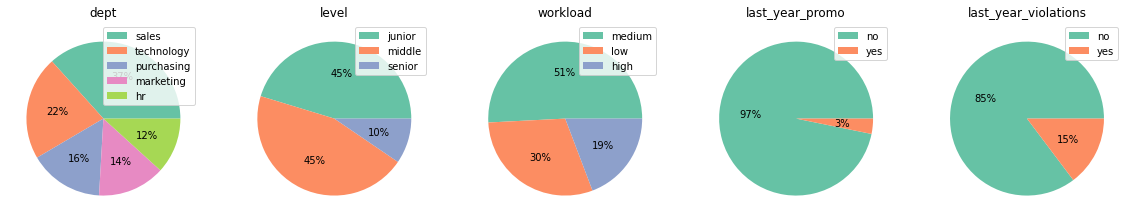

In [35]:
plot_pie(satisfaction_train)
    

- Самый многочисленный отдел - отдел продаж. На втором месте - технологический отдел
- В компании примерно поровну junior и middle специалистов. Senior специалисты составляют 10%
- Половина сотрудников имеют среднюю нагрузку. У 19% она высокая
- Практически все сотрудники не получали повышений ха последний год (97%)
- Нарушали условие трудового договора за последний год 15% сотрудников

**Посмотрим на числовые данные**

Основные числовые характеристики столбца employment_years:
count    3755.000000
mean        3.817044
std         2.557142
min         1.000000
25%         2.000000
50%         3.000000
75%         6.000000
max        10.000000
Name: employment_years, dtype: float64


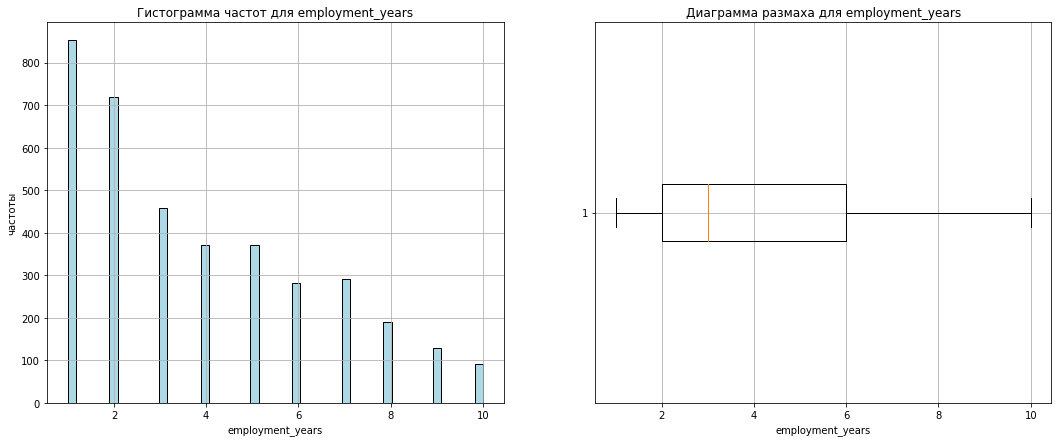

--------------------------------------------------------------------------------------------------------------

Основные числовые характеристики столбца supervisor_evaluation:
count    3755.000000
mean        3.463648
std         1.026265
min         1.000000
25%         3.000000
50%         4.000000
75%         4.000000
max         5.000000
Name: supervisor_evaluation, dtype: float64


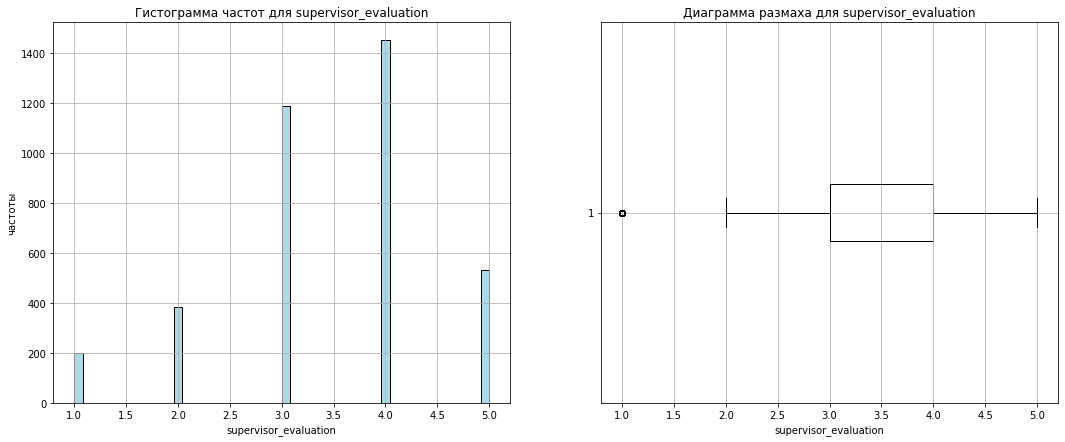

--------------------------------------------------------------------------------------------------------------

Основные числовые характеристики столбца salary:
count     3755.000000
mean     34457.416778
std      15050.643870
min      12000.000000
25%      22800.000000
50%      31200.000000
75%      44400.000000
max      98400.000000
Name: salary, dtype: float64


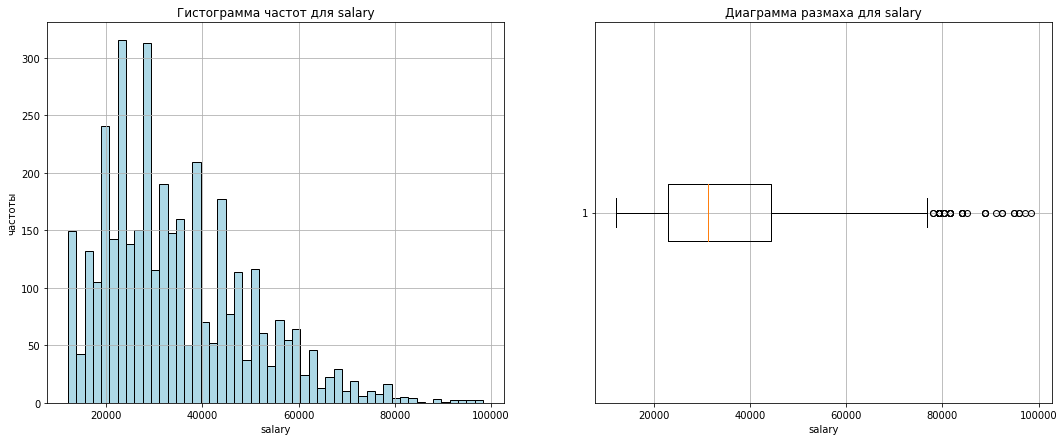

--------------------------------------------------------------------------------------------------------------

Основные числовые характеристики столбца job_satisfaction_rate:
count    3755.000000
mean        0.532554
std         0.226393
min         0.030000
25%         0.350000
50%         0.550000
75%         0.710000
max         1.000000
Name: job_satisfaction_rate, dtype: float64


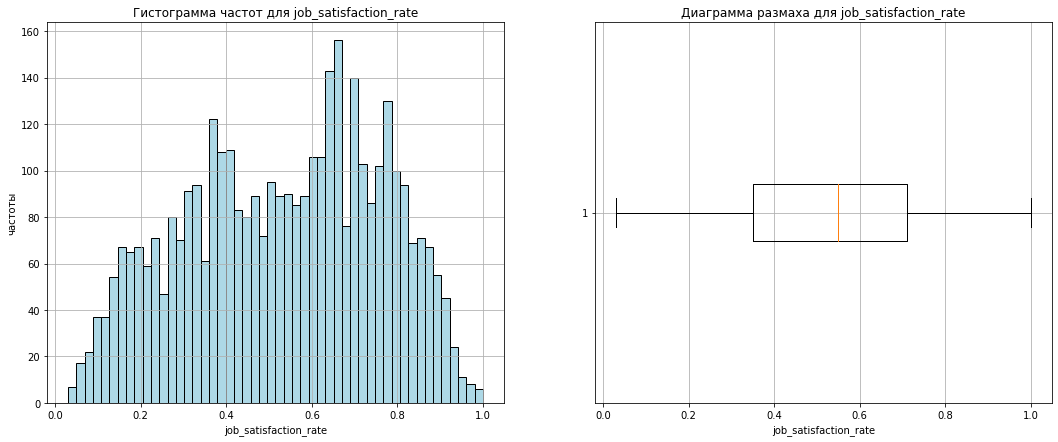

--------------------------------------------------------------------------------------------------------------



In [36]:
for i in satisfaction_train.select_dtypes(exclude = 'object'):
    plot_hist_and_boxplot(satisfaction_train[i])

- Большая часть сотрцдников проработала в компании до трех лет
- Чаще всего руководители оценивали своих сторников на 4 по шкале от 1 до 5. На втором месте по частоте оценка 3. Самая редкая оценка - 1
- Распределение зарплат нессиметричное и смещено влево. Большая часть сотрудников находится левее медианной зарплаты(30тыс). Согласно диаграмме размаха зарплата выше 70тыс является редкостью
- Распределение целевого признака `уровень_удовлетворенности` носит скорее равномерный характер, значения имеют довольно широкий разброс, что отражается стандартным отклонением ~  0.23. Медиана и среднее находятся посередине между 0 и 1 и составляют ~ 0.55 и 0.53 соответвенно

**Построим диаграммы рассеяния целевого признака `job_satisfaction_train` с остальными числовыми признаками, при этом добавив метки для категориальных данных**

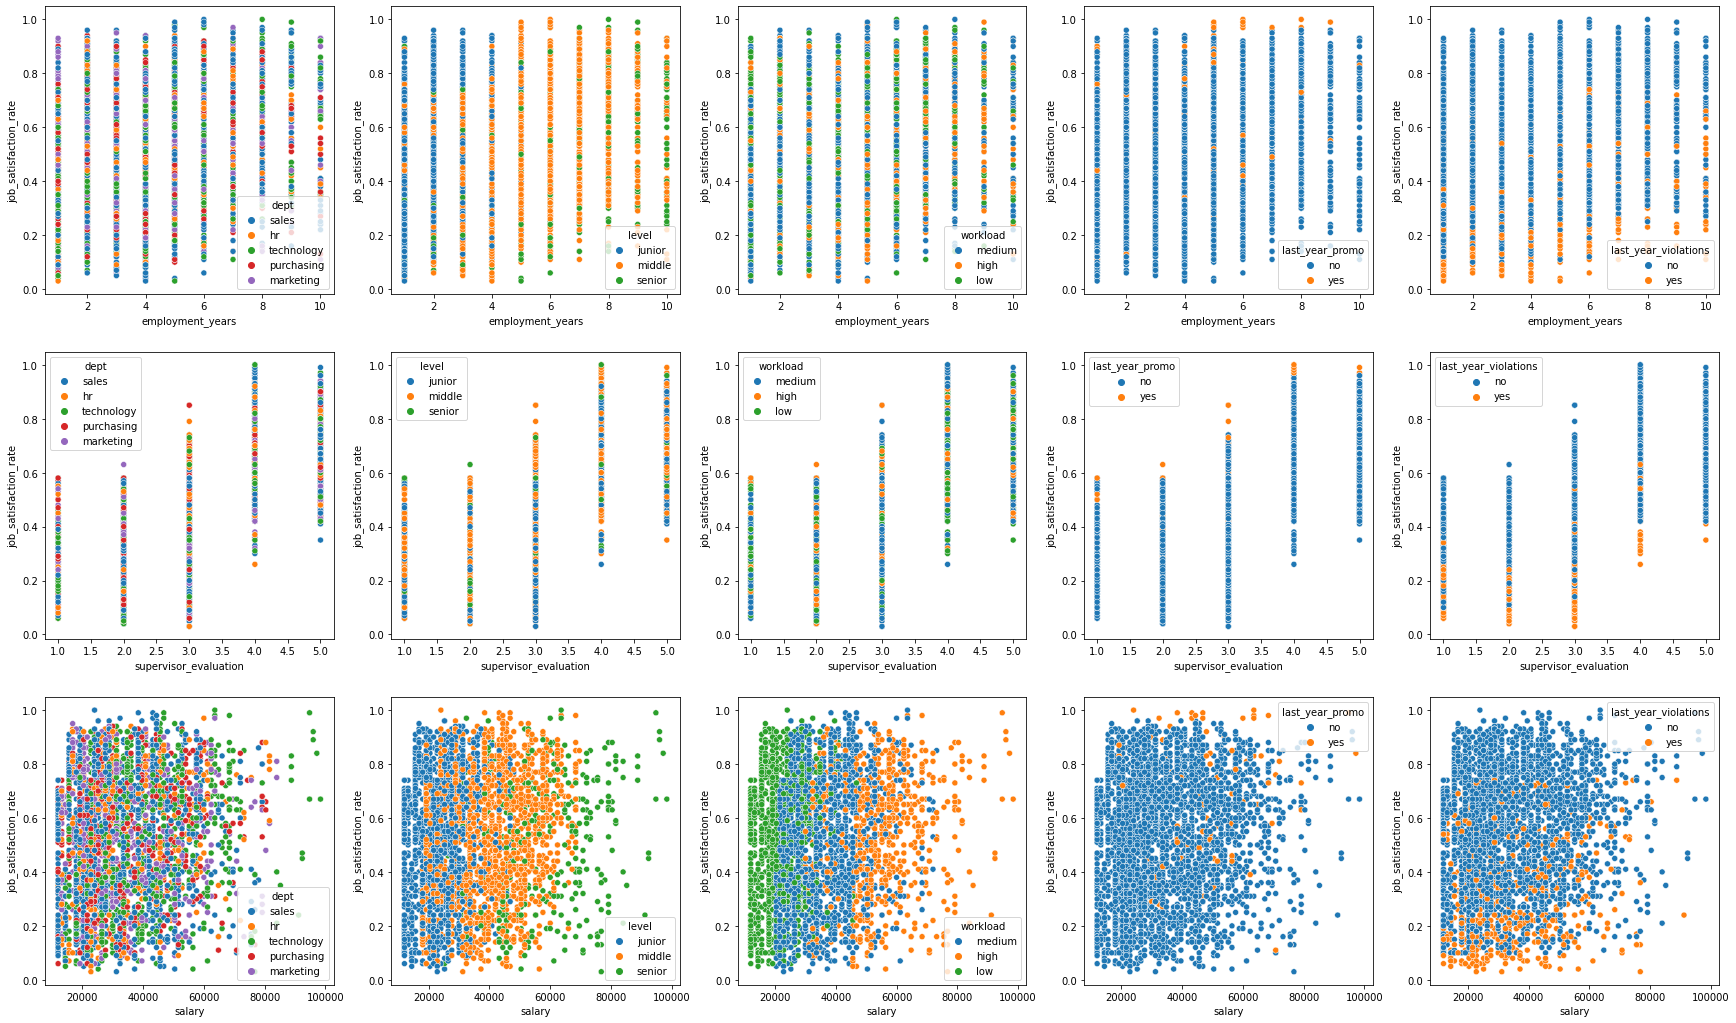

In [37]:
f, axs = plt.subplots(3, 5, figsize=(30, 18))
coun_ax_col = 0
for row, num_col in {0 :'employment_years',
                     1 : 'supervisor_evaluation',
                     2 : 'salary'}.items():

    for col, categ in {0: 'dept',
                       1 : 'level',
                       2: 'workload',
                       3: 'last_year_promo',
                       4: 'last_year_violations'}.items():

        
        sns.scatterplot(x= num_col,
        y='job_satisfaction_rate',
        hue=categ,
        data=satisfaction_train, ax=axs[row][col])


**По числовым данным:**
- На диаграммах рассеяния не заметная связь между уровнем удовлетворенности работника и продолжительностью его работы.
- Между уровнем удовлетвороренности и оценкой руководителя существует прямая связь
- Различима прямая зависимость между уровнем удовлетворенности и зарплатой

**По категориальным:**
- Наличие нарушений трудового договора за последний год очень часто характерно для низкого уровня удовлетворенности сотрудника
- Сотрудники получавшие повышение за последний год чаще всего имеют высокие значения уровня удовлетворенности
- Диаграмма рассяния уровня удовлетворенности и зарплаты, построенная с детализацией по уровню нагрузки(3 строка 3 столбец), демонстрирует довольно четкое разделение наблюдений по трем классам рабочей нагрузки. Это свидетельствует о справдливой дифференциации зарплат в соответсвии с рабочей нагрузкой. Такая же ситуацмя наблюдается для уровня проффесионализма(junior middle senior)

**Посмотрим на медианные значения удовлетворенности работников с детализацией по катеогриальным признакам**

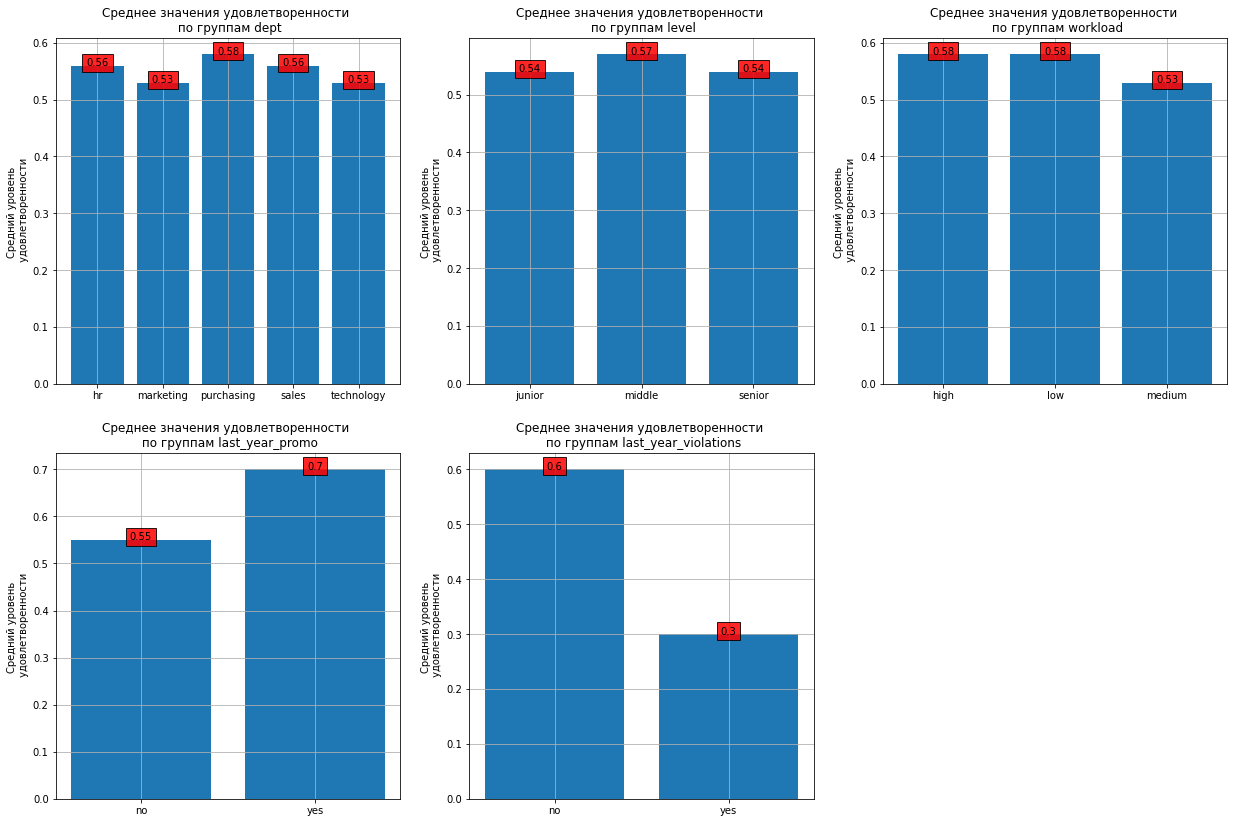

In [38]:

def addlabels (x,y):
    for i in range(len(x)):
        plt.text(x = i, y = y[i], s = y[i], ha='center', bbox = dict(facecolor = 'red', alpha =.85))


plt.figure(figsize=(21, 14))
for i, cat_col in enumerate(satisfaction_train.select_dtypes(include = 'object').columns):
    plt.subplot(2,3,i+1)
    pivot = satisfaction_train.pivot_table(index = cat_col, values= 'job_satisfaction_rate', aggfunc ='median')
    plt.bar(x= pivot.index, height = pivot['job_satisfaction_rate'])
    plt.title(f'Среднее значения удовлетворенности \n по группам {cat_col}')
    plt.ylabel('Средний уровень \n удовлетворенности')
    plt.grid()
    addlabels(pivot.index, pivot['job_satisfaction_rate'])

Медианный уровень удовлетворенности существенно варьируется по признакам наличия повышений за последний год и наличия нарушений трудового договора за последний год. 
- Работники, которых повышали за этот период имеют медианный уровень удовлетворенности на 0.15 выше (0.7 против 0.55 у тех кого не повышали)
- Работники, нарушавшие трудовой договор за последний год, имеют медианный уровень удовлетворенности на 0.30 ниже тех, кто не нарушал (0.60 у тех, кто не нарушал, и 0.30 у тех, кто нарушал)

**Теперь выделим тех кто имеет низкий уровень удовлетворенности (менее 0.25) и высокий уровень (более 0.75)**

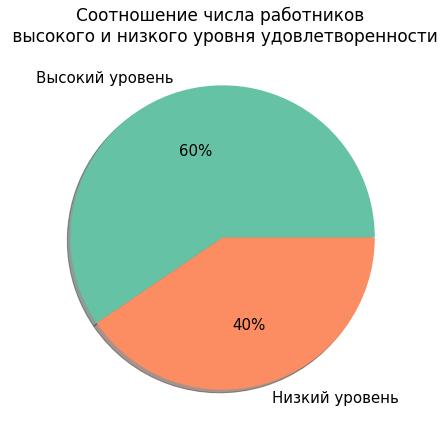

In [39]:
satisfaction_train_low = satisfaction_train.query('job_satisfaction_rate < 0.25')
satisfaction_train_high = satisfaction_train.query('job_satisfaction_rate > 0.75')
fig = plt.figure(figsize=(10, 7))
plt.pie(x = [satisfaction_train_high.shape[0], satisfaction_train_low.shape[0]], \
        labels = ['Высокий уровень', 'Низкий уровень'], autopct = '%1.0f%%', colors=sns.color_palette('Set2'), \
        shadow = True, textprops={'fontsize': 15})
plt.title('Соотношение числа работников \n высокого и низкого уровня удовлетворенности', fontdict = {'fontsize' : 17})
plt.show()

**Хорошая новость, работников с высоким уровнем больше!**

**Сравним категориальные признаки для высокого и низкого уровня удовлетворенности. Первая строчка для высокого уровня, вторая для низкого**

Высокий уровень удовлетворенности


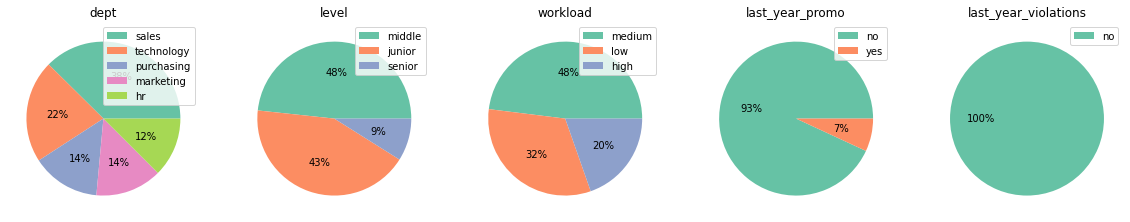

Низкий уровень удовлетворенности


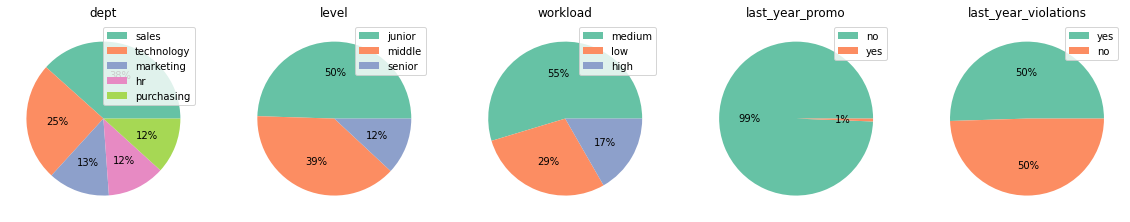

In [40]:
for name, dataset in {'Высокий уровень' : satisfaction_train_high ,  'Низкий уровень' : satisfaction_train_low }.items():
    print(name, 'удовлетворенности')
    plot_pie(dataset)
    plt.show()

- Работники высокого и низкого уровня удовлетворенности одинаково распределены по отделам. Значит проблемных отделов нет
- Среди работников с высоким уровнем удовлетворенности процент получавших повышение в 7 раз выше этого же процента в выборки работников с низким уровнем удовлетворенности
- Самое яркое различие между работниками с низкой и высокой удовлетворенностью заключается в наличии нарушений трудового договора. У работников с высоким уровнем удовлетворенности вообще нет нарушений, в то время как половина неудовлетворенных сотрудников нарушали трудовой договор

**Добавим в `satisfaction_train` новый признак `satisfaction_level`. Для высокого уровня `high`, для низкого `low`, для остальных `NaN`**

In [41]:
satisfaction_train['satisfaction_level'] = (satisfaction_train['job_satisfaction_rate']
                                      .apply(lambda x: 'high' if x > 0.75 else('low' if x < 0.25 else np.nan)))
satisfaction_train[['job_satisfaction_rate', 'satisfaction_level']]

,job_satisfaction_rate,satisfaction_level
id,,
155278,0.58,NaN
653870,0.76,high
184592,0.11,low
171431,0.37,NaN
693419,0.20,low
...,...,...
424345,0.88,high
855240,0.27,NaN
533318,0.76,high


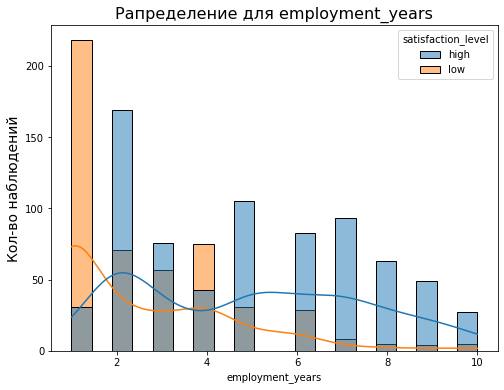

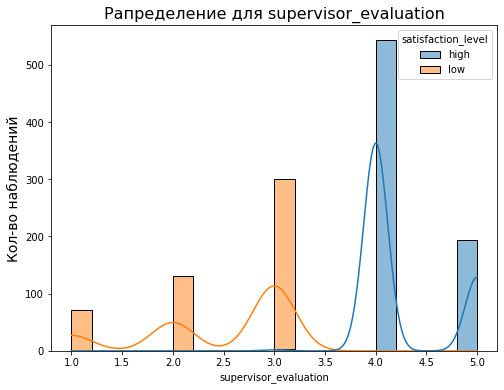

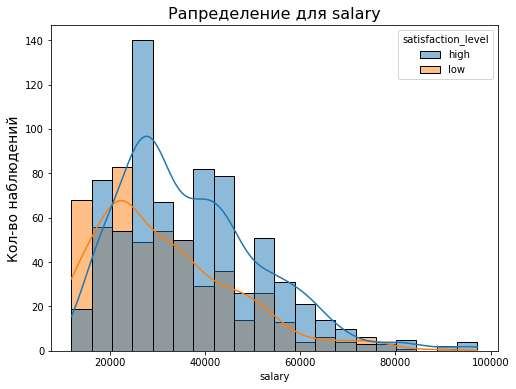

In [42]:
for col in satisfaction_train.drop('job_satisfaction_rate', axis = 1).select_dtypes(exclude = 'object').columns:
    plot_hist(satisfaction_train, col, 'satisfaction_level')

- Среди работников с низким уровнем удовлетворенности очень много тех, кто отработал один год. Среди тех, кто отработал два года наоборот много тех, кто имеет высокий уровень удовлетворенности. Причем для трех и более лет количество работников с высоким уровнем удовлетворенности заметно ниже чем для двух лет. Почему именно те, кто отработал два года, такие довольные?
- Среди тех, кто уже давно работает в компании (более 4 лет), заметно больше работников с высоким уровнем удовлетворенности
- Работники с низким уровнем удовлетворенности никогда не получали оценку от руководителя выше тройки. Среди тех, кто получил 4 и 5 наоборот одни довольные работники только
- Распределние зарплат довольных работников смещено праваее распределния зарплат недовольных работников. Для довольных работников характерны более высокие зарплаты

#### Корреляционный анализ `satisfaction_train`

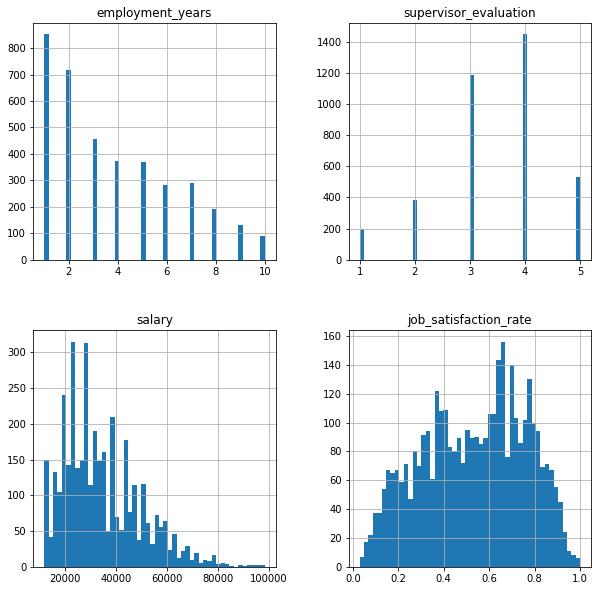

In [43]:
satisfaction_train.hist(figsize = (10,10), bins = 50)
plt.show()

Распределения числовых признаков не похожи на нормальное, к тому же среди признаков много категориальных. Восполльзуемся phik методом

Будет происходить утечка целевого признака через признак `satisfaction_level`, который был создан во время исследовательского анализа. Его следует удалить, больше он не нужен

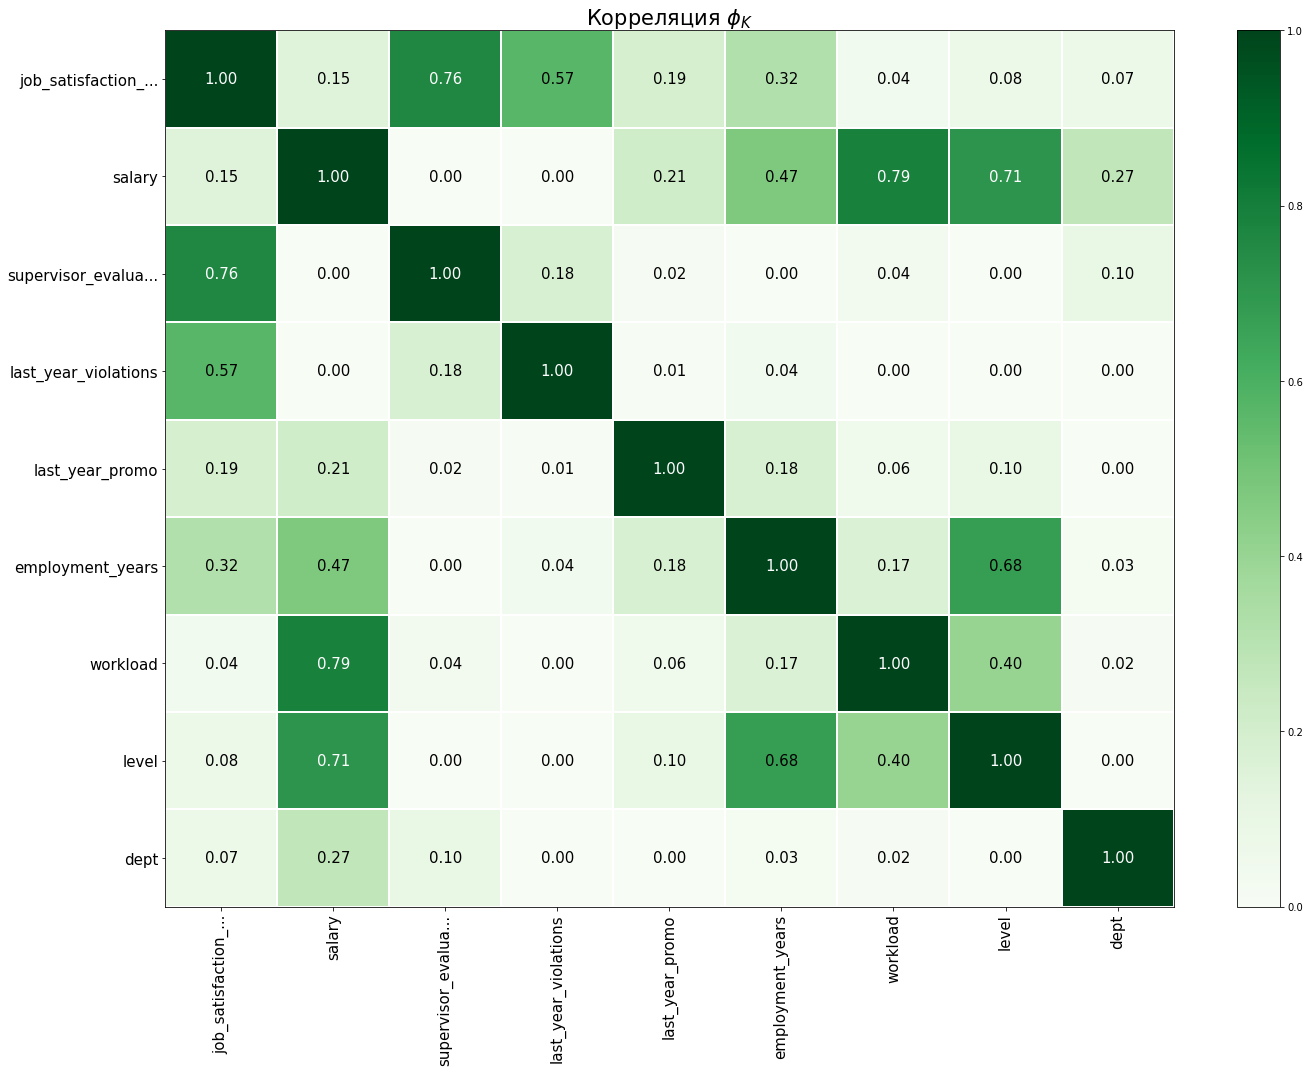

In [44]:
satisfaction_train = satisfaction_train.drop('satisfaction_level', axis = 1 )
interval_cols = ['employment_years', 'supervisor_evaluation', 'salary', 'job_satisfaction_rate']
phik_overview = phik_matrix(satisfaction_train, interval_cols=interval_cols) 


plot_correlation_matrix(
    phik_overview.values,
    x_labels=phik_overview.columns,
    y_labels=phik_overview.index,
    vmin=0, vmax=1, color_map='Greens',
    title=r'Корреляция $\phi_K$',
    fontsize_factor=1.5,
    figsize=(20, 15)
) 

Как и предполагалось, уровень удовлетворенности коррелирует с оценкой руководителя, наличием нарушений трудового договора за последний год, наличием повышений за последний год. Также, уровень удвовлетворенности коррелирует с продолжительностью работы сотрудника в компании. 


**Согласно шкале Чеддока высокая сила связи у пар признаков:**
- `job_satisfaction` и `supervisor_evaluation` (0.76)
- `salary` и `workload` (0.79)
- `salary` и `level` (0.71)


**Средняя сила связи у пар признаков:**
- `job_satisfaction` и `last_year_violations`(0.56)
- `employment_years` и `level` (0.68)


**Слабая сила связи у пар признаков:**
- `job_satisfaction` и `employment_years` (0.33)
- `salary` и `employment_years` (0.48)
- `salary` и `dept` (0.30)
- `level` и `workload` (0.44)


**Остальные возможные пары признаков имеют очень слабую силу связи**

Признак `dept` очень слабо коррелирует со всеми остальными признаками, кроме `salary`, с которым у него просто слабая связь. Возможно информация об отделе, в котором работник трудится, не будет иметь ценности для модели


Мультиколинерность между признаками обнаружена не была


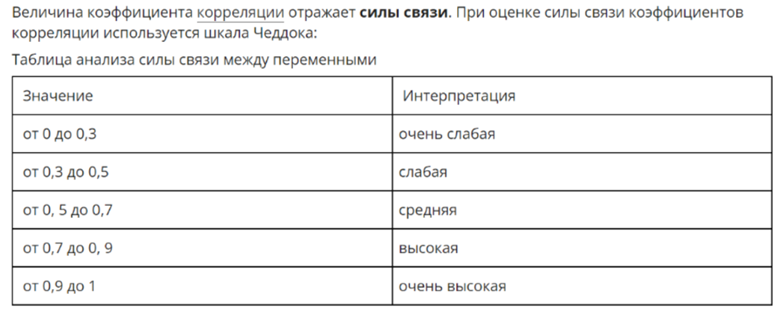

**Вывод по разделу `Исследовательский анализ satisfaction_train`**

- Самый многочисленный отдел - отдел продаж. На втором месте - технологический отдел
- В компании примерно поровну junior и middle специалистов. Senior специалисты составляют 9%
- Половина сотрудников имеют среднюю нагрузку. У 18% она высокая
- Практически все сотрудники не получали повышений за последний год (97%)
- Нарушали условие трудового договора за последний год 14% сотрудников




- Среди сотрудников компании много тех, кто проработал до трех лет
- Чаще всего руководители оценивали своих сотрудников на 4 по шкале от 1 до 5. На втором месте по частоте оценка 3. Самая редкая оценка - 1
- Распределение зарплат нессиметричное и смещено влево. Большая часть сотрудников находится левее медианной зарплаты(30тыс). Согласно диаграмме размаха зарплата выше 70тыс является редкостью
- Распределение целевого признака `уровень_удовлетворенности` носит скорее равномерный характер, значения имеют довольно широкий разброс, что отражается стандартным отклонением ~  0.24. Медиана и среднее находятся посередине между 0 и 1 и составляют ~ 0.56 и 0.53 соответвенно




- Между уровнем удовлетвороренности и оценкой руководителя существует прямая связь
- Различима прямая зависимость между уровнем удовлетворенности и зарплатой
- Наличие нарушений трудового договора за последний год очень часто характерно для низкого уровня удовлетворенности сотрудника






- Медианный уровень удовлетворенности существенно варьируется по признакам наличия повышений за последний год и наличия нарушений трудового договора за последний год. 
- Работники, которых повышали за этот период имеют медианный уровень удовлетворенности на 0.13 выше (0.69 против 0.56 у тех кого не повышали)
- Работники, нарушавшие трудовой договор за последний год, имеют медианный уровень удовлетворенности на 0.31 ниже тех, кто не нарушал (0.61 у тех, кто не нарушал, и 0.3 у тех, кто нарушал)




**Введем определение. Работники с низким уровнем удовлетворенности это < 0.25. Работники с выоским уровнем удовлетворенности это > 0.75**
- Работники высокого и низкого уровня удовлетворенности одинаково распределены по отделам. Значит проблемных отделов нет
- Среди работников с высоким уровнем удовлетворенности процент получавших повышение в 7 раз выше этого же процента в выборке работников с низким уровнем удовлетворенности
- Самое яркое различие между работниками с низкой и высокой удовлетворенностью заключается в наличии нарушений трудового договора. У работников с высоким уровнем удовлетворенности вообще нет нарушений, в то время как половина неудовлетворенных сотрудников нарушали трудовой договор




- Среди работников с низким уровнем удовлетворенности очень много тех, кто отработал один год. Среди тех, кто отработал два года наоборот много тех, кто имеет высокий уровень удовлетворенности. Причем для трех и более лет количество работников с высоким уровнем удовлетворенности заметно ниже чем для двух лет. Почему именно те, кто отработал два года, такие довольные?
- Среди тех, кто уже давно работает в компании (более 4 лет), заметно больше работников с высоким уровнем удовлетворенности
- Работники с низким уровнем удовлетворенности никогда не получали оценку от руководителя выше тройки. Среди тех, кто получил 4 и 5 наоборот одни довольные работники только
- Распределние зарплат довольных работников смещено праваее распределния зарплат недовольных работников. Для довольных работников характерны более высокие зарплаты



**Таким образом, наиболее существенными показателями можно считать: наличие нарушений трудового договора, наличие повышений, оценка руководителя и уровень зарплаты. Принадлежность к какому-либо отделу скорее всего не влияет на уровень удовлетворенности**

#### Исследовательский анализ `satisfaction_test`

In [45]:
satisfaction_test.head()

,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,job_satisfaction_rate
id,,,,,,,,,
100298,hr,junior,low,2,no,no,4,19200,0.80
100480,marketing,junior,low,4,no,no,4,16800,0.84
100503,purchasing,middle,high,5,no,no,4,55200,0.79
100610,sales,middle,medium,5,no,no,4,43200,0.75
100692,sales,middle,high,6,no,no,4,48000,0.69


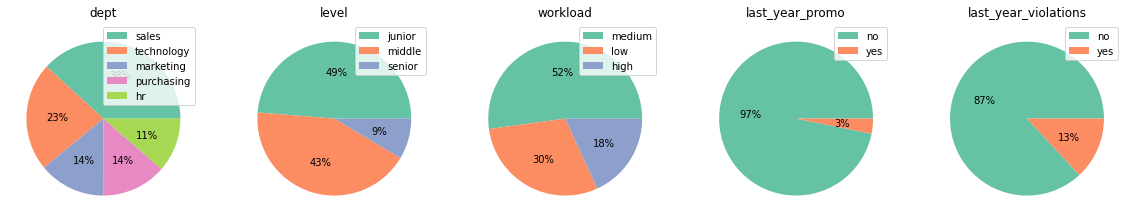

In [46]:
plot_pie(satisfaction_test)

**Ситуация с категориальными данными идентична `satisfaction_train`**

Основные числовые характеристики столбца employment_years:
count    2000.000000
mean        3.666500
std         2.537222
min         1.000000
25%         1.000000
50%         3.000000
75%         6.000000
max        10.000000
Name: employment_years, dtype: float64


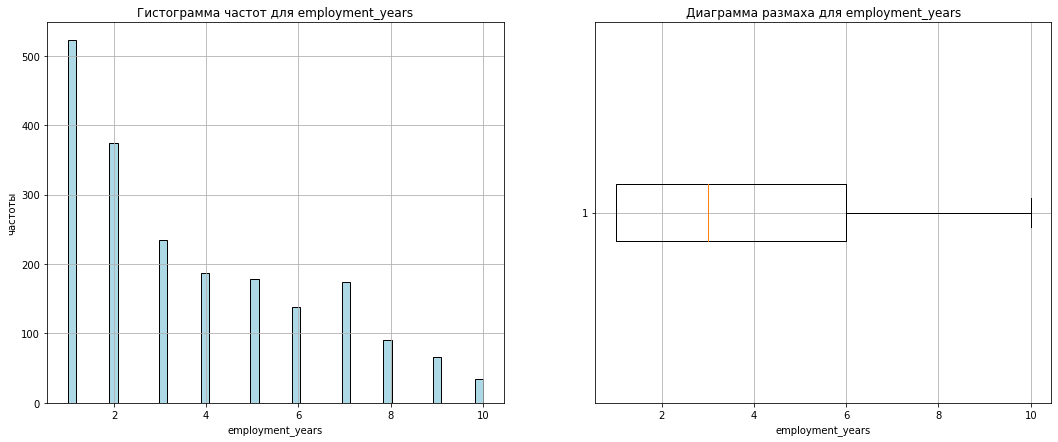

--------------------------------------------------------------------------------------------------------------

Основные числовые характеристики столбца supervisor_evaluation:
count    2000.000000
mean        3.526500
std         0.996892
min         1.000000
25%         3.000000
50%         4.000000
75%         4.000000
max         5.000000
Name: supervisor_evaluation, dtype: float64


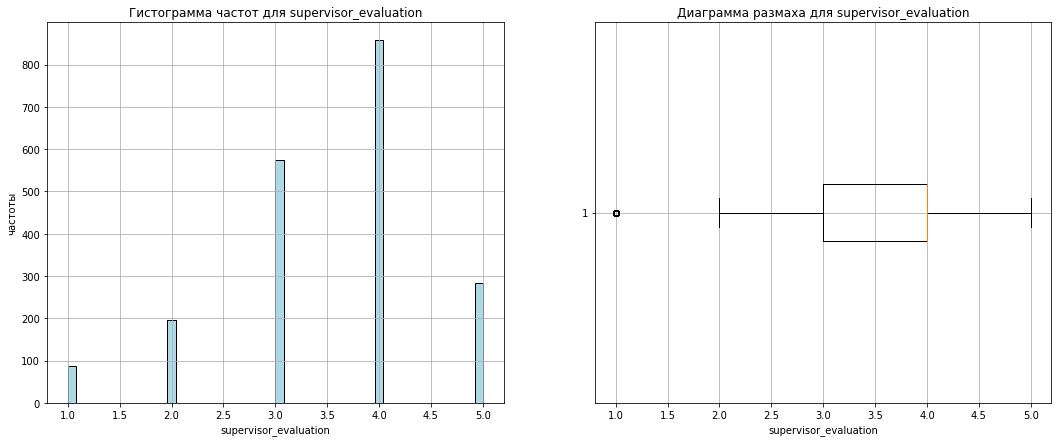

--------------------------------------------------------------------------------------------------------------

Основные числовые характеристики столбца salary:
count     2000.000000
mean     34066.800000
std      15398.436729
min      12000.000000
25%      22800.000000
50%      30000.000000
75%      43200.000000
max      96000.000000
Name: salary, dtype: float64


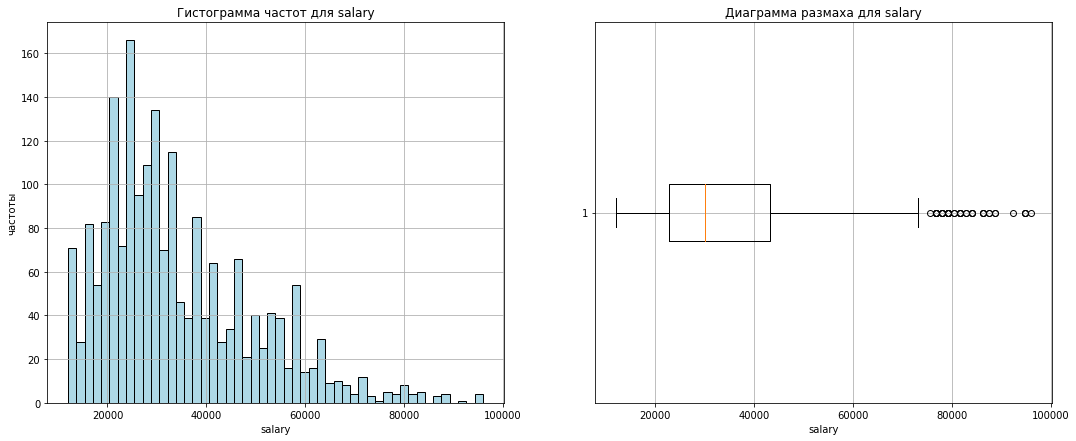

--------------------------------------------------------------------------------------------------------------

Основные числовые характеристики столбца job_satisfaction_rate:
count    2000.00000
mean        0.54878
std         0.22011
min         0.03000
25%         0.38000
50%         0.58000
75%         0.72000
max         1.00000
Name: job_satisfaction_rate, dtype: float64


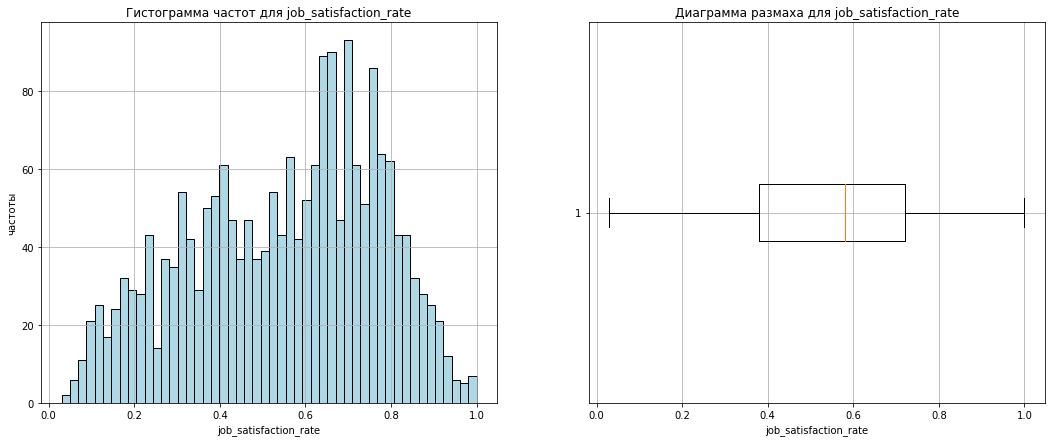

--------------------------------------------------------------------------------------------------------------



In [47]:
for i in satisfaction_test.select_dtypes(exclude = 'object'):
    plot_hist_and_boxplot(satisfaction_test[i])

**Такие же формы распределений гистограмм, как и на тренировочной выборке**

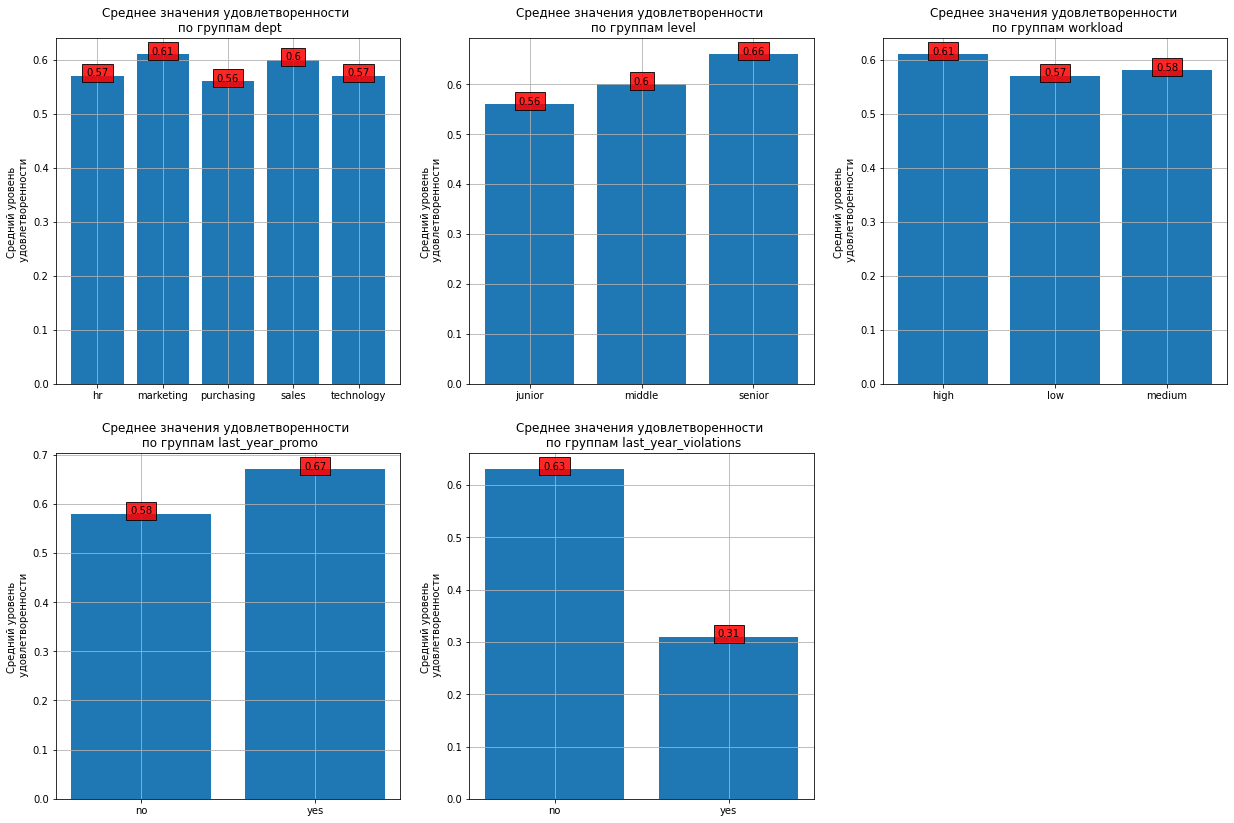

In [48]:


plt.figure(figsize=(21, 14))
for i, cat_col in enumerate(satisfaction_test.select_dtypes(include = 'object').columns):
    plt.subplot(2,3,i+1)
    pivot = satisfaction_test.pivot_table(index = cat_col, values= 'job_satisfaction_rate', aggfunc ='median')
    plt.bar(x= pivot.index, height = pivot['job_satisfaction_rate'])
    plt.title(f'Среднее значения удовлетворенности \n по группам {cat_col}')
    plt.ylabel('Средний уровень \n удовлетворенности')
    plt.grid()
    addlabels(pivot.index, pivot['job_satisfaction_rate'])

**Средний уровень удовлетворенности на тестовой выборке варьируется по признаку `last_yeat_promo` слабее. Здесь средние значения удовлетворенности работников, у которых было повышение и не было, отличаются на 9процентных пунктов, а не на 15, как на тренировочных данных**

**Еще одно отличие между тренировочной и тестовой выборкой в том, что на тестовой наибольший средний уровень удовлетворенности имеют senior работники, а не middle**

**Теперь выделим тех кто имеет низкий уровень удовлетворенности (менее 0.25) и высокий уровень (более 0.75)**

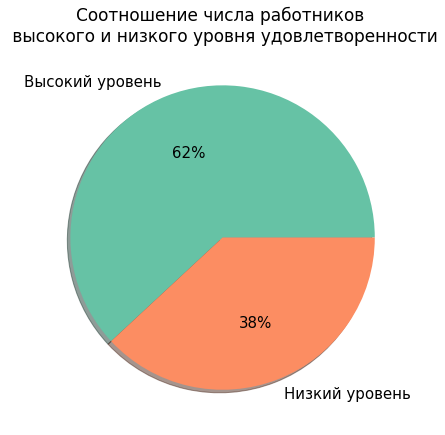

In [49]:
satisfaction_test_low = satisfaction_test.query('job_satisfaction_rate < 0.25')
satisfaction_test_high = satisfaction_test.query('job_satisfaction_rate > 0.75')
fig = plt.figure(figsize=(10, 7))
plt.pie(x = [satisfaction_test_high.shape[0], satisfaction_test_low.shape[0]], \
        labels = ['Высокий уровень', 'Низкий уровень'], autopct = '%1.0f%%', colors=sns.color_palette('Set2'), \
        shadow = True, textprops={'fontsize': 15})
plt.title('Соотношение числа работников \n высокого и низкого уровня удовлетворенности', fontdict = {'fontsize' : 17})
plt.show()

Cоотношение между работниками с высоким и низким уровнем удовлетворенности для тестовой выботки такое же, как для тренировочной

**Добавим в `satisfaction_test` новый признак `satisfaction_level`. Для высокого уровня `high`, для низкого `low`, для остальных `NaN`**

In [50]:
satisfaction_test['satisfaction_level'] = (satisfaction_test['job_satisfaction_rate']
                                      .apply(lambda x: 'high' if x > 0.75 else('low' if x < 0.25 else np.nan)))
satisfaction_test[['job_satisfaction_rate', 'satisfaction_level']]

,job_satisfaction_rate,satisfaction_level
id,,
100298,0.80,high
100480,0.84,high
100503,0.79,high
100610,0.75,NaN
100692,0.69,NaN
...,...,...
997290,0.79,high
998548,0.76,high
998762,0.48,NaN


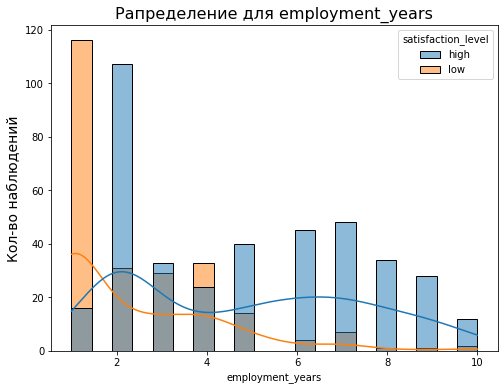

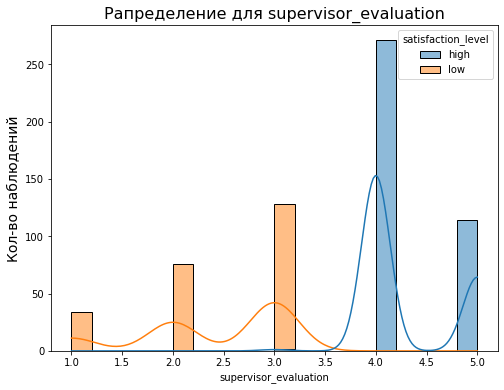

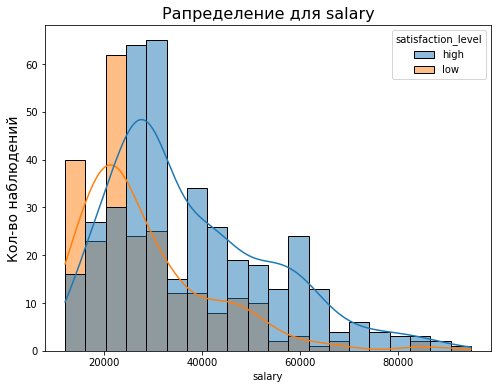

In [51]:
for col in satisfaction_test.drop('job_satisfaction_rate', axis = 1).select_dtypes(exclude = 'object').columns:
    plot_hist(satisfaction_test, col, 'satisfaction_level')

**Здесь для тестовой выборки справедливы те же законометрности, что и для тренировочной. Единственное отличие состоит в гистограммах для зарплаты. На тестовой выборке наблюдается более выраженный пик около зарплаты в 30.000 для обеих групп по уровню удовлетворенности**

#### Корреляционный анализ `satisfaction_test`

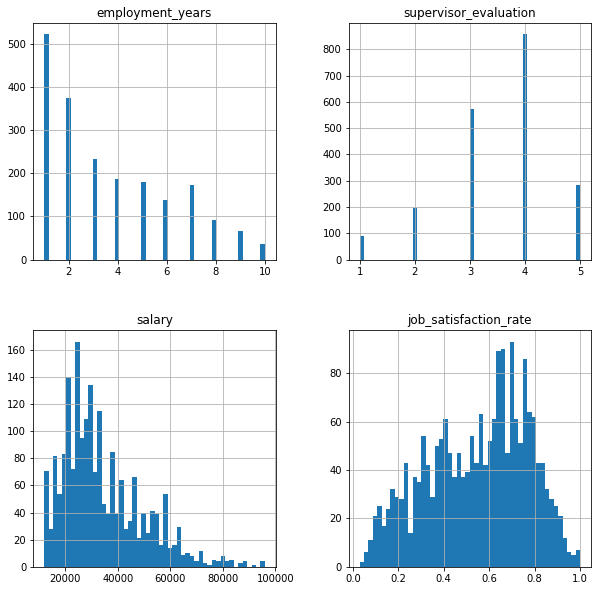

In [52]:
satisfaction_test.hist(figsize = (10,10), bins = 50)
plt.show()

Распределения числовых признаков не похожи на нормальное, к тому же среди признаков много категориальных. Восполльзуемся phik методом

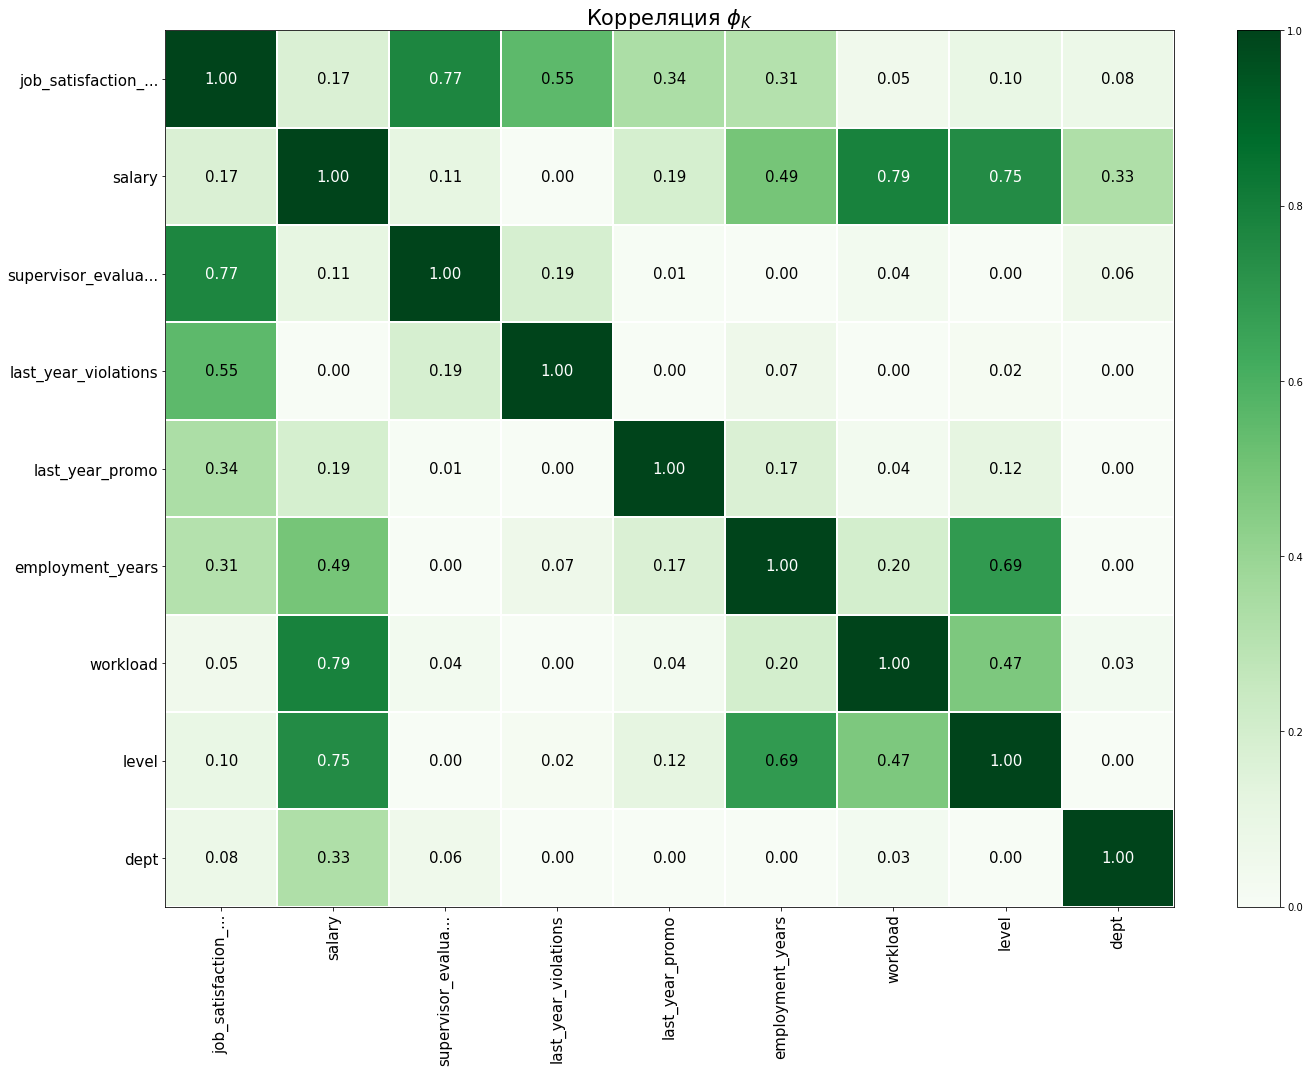

In [53]:
satisfaction_test = satisfaction_test.drop('satisfaction_level', axis = 1 )
interval_cols = ['employment_years', 'supervisor_evaluation', 'salary', 'job_satisfaction_rate']
phik_overview = phik_matrix(satisfaction_test, interval_cols=interval_cols) 


plot_correlation_matrix(
    phik_overview.values,
    x_labels=phik_overview.columns,
    y_labels=phik_overview.index,
    vmin=0, vmax=1, color_map='Greens',
    title=r'Корреляция $\phi_K$',
    fontsize_factor=1.5,
    figsize=(20, 15)
) 

**Корреляция на тренировочных:**

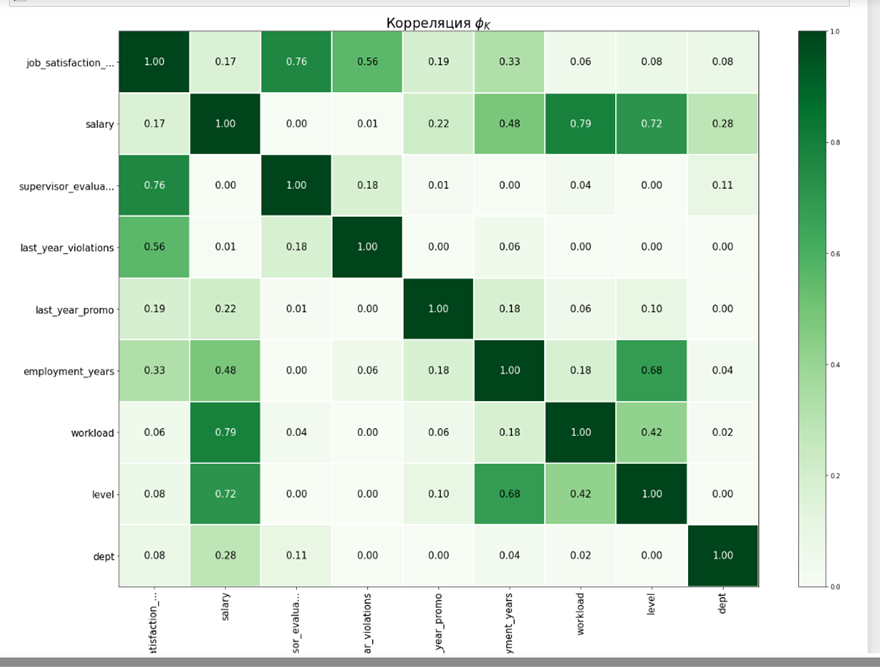

- На тестовых данный целевой признак `job_satisfaction_rate` сильнее коррелирует с признаком `last_year_promo` (0.34 против 0.19 на тренировочных)
- На тестовых данных `salary` коррелирует с `supervisor_evaluation`(0.11). На тренировочных данных корреляции не было совсем
- На тестовой выборке наблюдается более выраженный пик около зарплаты в 30.000 для обеих групп по уровню удовлетворенности




**Вывод по разделу `Исследовательский анализ данных satisfaction_test`**
Данные тестовой выборки очень похожи на данные тренировочной. Однако есть некоторые различия, такие как:
- На тестовых данный целевой признак `job_satisfaction_rate` сильнее коррелирует с признаком `last_year_promo` (0.34 против 0.19 на тренировочных)
- На тестовых данных `salary` коррелирует с `supervisor_evaluation`(0.11). На тренировочных данных корреляции не было совсем
- Средний уровень удовлетворенности на тестовой выборке варьируется по признаку `last_yeat_promo` слабее. Здесь средние значения удовлетворенности работников, у которых было повышение и не было, отличаются на 9процентных пунктов, а не на 15, как на тренировочных данных
- наибольший средний уровень удовлетворенности имеют senior работники, а не middle

### Подготовка данных

In [54]:
satisfaction_train.head()

,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,job_satisfaction_rate
id,,,,,,,,,
155278,sales,junior,medium,2,no,no,1,24000,0.58
653870,hr,junior,high,2,no,no,5,38400,0.76
184592,sales,junior,low,1,no,no,2,12000,0.11
171431,technology,junior,low,4,no,no,2,18000,0.37
693419,hr,junior,medium,1,no,no,3,22800,0.20


In [55]:
satisfaction_X_test.head()

,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary
id,,,,,,,,
100298,hr,junior,low,2,no,no,4,19200
100480,marketing,junior,low,4,no,no,4,16800
100503,purchasing,middle,high,5,no,no,4,55200
100610,sales,middle,medium,5,no,no,4,43200
100692,sales,middle,high,6,no,no,4,48000


In [56]:
satisfaction_y_test.head()

,job_satisfaction_rate
id,
100298,0.80
100480,0.84
100503,0.79
100610,0.75
100692,0.69


Подготовка данных и заполнение пропусков будут произведены в итоговом пайплайне. Ohe кодирование для колонок:

- `last_year_promo`
- `last_year_violations`

Ord кодирование для колонок:
- `level`
- `workload`

StandardScaler или MinMaxScaler для колонок:
- `employment_years`
- `supervisor_evaluation`
- `salary`

### Обучение моделей

**Попробуем три модели: линейную регрессию, регрессию дерева решений и случайный лес. Для дерева решений переберем параметры:**
- max_depth (от 2 до 22)
- min_samples_split (от 2 до 22)
- max_features (от 2 до 22)

Для случайного леса те же параметры, что и для дерева решений, плюс еще один:
- n_estimators (от 100 до 1000)

**При подготовке числовых данных будем пробовать два кодировщика. StandardScaler и MinMaxScaler. Методом проб и ошибок было установлено, что без признака `dept` модель демонтрирует лучшую метрику smape как на кроссвалидации, так и на тесте**

In [57]:
warnings.filterwarnings('ignore')



ohe_columns = ['last_year_promo', 'last_year_violations']
ord_columns = ['level', 'workload']
num_columns = ['employment_years', 'supervisor_evaluation', 'salary']

RANDOM_STATE = 42


ohe_pipe = Pipeline(
    [('simpleImputer_ohe', SimpleImputer(missing_values= np.nan, strategy = 'most_frequent')),
      ('ohe', OneHotEncoder(drop = 'first', handle_unknown = 'error')) #ПРАВКА РЕВЬЮЕРА
    ]
)



ord_pipe = Pipeline(
    [('simpleImputer_before_ord', SimpleImputer(missing_values = np.nan, strategy = 'most_frequent')),
     ('ord', OrdinalEncoder(categories = [['junior', 'middle', 'senior'],
                                         ['low', 'medium','high']],
                           handle_unknown = 'use_encoded_value', unknown_value = np.nan)),
     ('simpleImputer_after_ord', SimpleImputer(missing_values = np.nan, strategy = 'most_frequent'))
    ]
)


data_preprocessor = ColumnTransformer(
    [('ohe', ohe_pipe, ohe_columns),
     ('ord', ord_pipe, ord_columns),
     ('num', StandardScaler(), num_columns)
    ],
    remainder = 'passthrough'
)


pipe_final = Pipeline(
    [('preprocessor', data_preprocessor),
     ('models', LinearRegression())
    ]
)

param_grid = [
    {
        'models' : [DecisionTreeRegressor(random_state=RANDOM_STATE)],
        'models__max_depth' : range(2, 22),
        'models__min_samples_split' : range(2, 22), 
        'models__max_features' : range(2,22),
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']
    },
    {
        'models' : [LinearRegression()],
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']
    },
    {
        'models' : [RandomForestRegressor(random_state = RANDOM_STATE)],
        'models__max_depth' : range(2, 22),
        'models__min_samples_split' : range(2, 22), 
        'models__max_features' : range(2,22),
        'models__n_estimators' : range(100, 1000),
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']        
    }
    
]

#создаем метрику smape
def smape_score(y_true, y_pred):
    smape = 100/len(y_true)* np.sum(abs(y_true - y_pred)/((abs(y_true)+abs(y_pred))/2))
    return smape

scorer = make_scorer(score_func=smape_score, greater_is_better=False) 


randomized_search = RandomizedSearchCV(
    pipe_final,
    param_grid,
    cv = 5,
    scoring= scorer,
    random_state = RANDOM_STATE,
    n_jobs = -1,
    n_iter=50
)



X_train = satisfaction_train.drop('job_satisfaction_rate', axis =1)
X_train = X_train.drop('dept', axis = 1)
y_train = satisfaction_train['job_satisfaction_rate']
randomized_search.fit(X_train, y_train)

RandomizedSearchCV(cv=5,
                   estimator=Pipeline(steps=[('preprocessor',
                                              ColumnTransformer(remainder='passthrough',
                                                                transformers=[('ohe',
                                                                               Pipeline(steps=[('simpleImputer_ohe',
                                                                                                SimpleImputer(strategy='most_frequent')),
                                                                                               ('ohe',
                                                                                                OneHotEncoder(drop='first'))]),
                                                                               ['last_year_promo',
                                                                                'last_year_violations']),
                                               

In [58]:
print('Лучшая модель и её параметры:\n\n', randomized_search.best_estimator_)
print ('Метрика лучшей модели на кроссвалидации:', randomized_search.best_score_)

Лучшая модель и её параметры:

 Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ohe',
                                                  Pipeline(steps=[('simpleImputer_ohe',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('ohe',
                                                                   OneHotEncoder(drop='first'))]),
                                                  ['last_year_promo',
                                                   'last_year_violations']),
                                                 ('ord',
                                                  Pipeline(steps=[('simpleImputer_before_ord',
                                                                   SimpleImputer(strategy='most_frequent')),
                                        

In [59]:
randomized_search.best_params_

{'preprocessor__num': StandardScaler(),
 'models__n_estimators': 377,
 'models__min_samples_split': 9,
 'models__max_features': 7,
 'models__max_depth': 21,
 'models': RandomForestRegressor(max_depth=21, max_features=7, min_samples_split=9,
                       n_estimators=377, random_state=42)}

In [60]:
X_test = satisfaction_X_test.drop('dept', axis = 1)
y_pred = np.array(randomized_search.predict(X_test))
y_true = np.array(satisfaction_y_test).ravel()
metric = smape_score(y_true, y_pred)
print('Метрика на тестовой выборке', round(metric, 4))

Метрика на тестовой выборке 14.5788


**Вывод по разделу `Обучение моделей. Задача 1`**

В пайплайне методом случайного поиска были опробованы две модели: линейная регрессия и регрессия дерева решений. Для случайного леса подбирались параметры:
- max_depth (от 2 до 22)
- min_samples_split (от 2 до 22)
- max_features (от 2 до 22)
- n_estimators (от 100 до 1000)


При подготовке числовых данных пробовал два кодировщика. StandardScaler и MinMaxScaler

Качество модели оценивалось метрикой `smape` «симметричное среднее абсолютное процентное отклонение»

**Лучшая модель - случайный лес**
- `min_samples_split` -  9
- `max_features` -  7
- `max_depth` - 21
- `n_estimators` - 377

**Нужна метрика smape <= 15. Имеем  на кроссвалидации 15.91 и 14.58 на тесте**

## Задача 2: предсказание увольнения сотрудника из компании

### Загрузка данных

In [61]:
train_quit = pd.read_csv('https://code.s3.yandex.net/datasets/train_quit.csv')
test_features = satisfaction_X_test
test_target = pd.read_csv('https://code.s3.yandex.net/datasets/test_target_quit.csv')
train_quit.head()

,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,quit
0,723290,sales,middle,high,2,no,no,4,54000,no
1,814010,sales,junior,medium,2,no,no,4,27600,no
2,155091,purchasing,middle,medium,5,no,no,1,37200,no
3,257132,sales,junior,medium,2,no,yes,3,24000,yes
4,910140,marketing,junior,medium,2,no,no,5,25200,no


In [62]:
test_target.head()

,id,quit
0,999029,yes
1,372846,no
2,726767,no
3,490105,no
4,416898,yes


### Предобработка данных

#### Предобработка `train_quit`

In [63]:
train_quit.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 10 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   id                     4000 non-null   int64 
 1   dept                   4000 non-null   object
 2   level                  4000 non-null   object
 3   workload               4000 non-null   object
 4   employment_years       4000 non-null   int64 
 5   last_year_promo        4000 non-null   object
 6   last_year_violations   4000 non-null   object
 7   supervisor_evaluation  4000 non-null   int64 
 8   salary                 4000 non-null   int64 
 9   quit                   4000 non-null   object
dtypes: int64(4), object(6)
memory usage: 312.6+ KB


**Типы данных корректны. Пропусков нет. Посмотрим на уникальные значения**

In [64]:
print_uniq_values(train_quit)

Столбец - dept
Кол-во уникальных значений:  5
['sales' 'purchasing' 'marketing' 'technology' 'hr']

--------------------------------------------------
Столбец - level
Кол-во уникальных значений:  3
['middle' 'junior' 'sinior']

--------------------------------------------------
Столбец - workload
Кол-во уникальных значений:  3
['high' 'medium' 'low']

--------------------------------------------------
Столбец - last_year_promo
Кол-во уникальных значений:  2
['no' 'yes']

--------------------------------------------------
Столбец - last_year_violations
Кол-во уникальных значений:  2
['no' 'yes']

--------------------------------------------------
Столбец - quit
Кол-во уникальных значений:  2
['no' 'yes']

--------------------------------------------------


**Заменим `sinior` на `senior`**

In [65]:
train_quit['level'] = train_quit['level'].str.replace('sinior', 'senior')
train_quit['level'].unique()

array(['middle', 'junior', 'senior'], dtype=object)

In [66]:
train_quit.duplicated().sum()

0

In [67]:
train_quit.drop('id', axis = 1).duplicated().sum()

1413

In [68]:
train_quit.shape

(4000, 10)

<div class="alert alert-info">
Очень много дупликатов, примерно 35% датасета. Тем не менее, их нужно удалить, чтобы на кроссвалидации одни и те же строки не попадали в тренировочную и тестовую выборку
</div>

In [69]:
col_list2 = train_quit.drop('id', axis = 1).columns.to_list()
train_quit.drop_duplicates(subset = col_list2, inplace = True )
train_quit.drop('id', axis = 1).duplicated().sum()

0

#### Предобработка `test_target`

In [70]:
test_target.head()

,id,quit
0,999029,yes
1,372846,no
2,726767,no
3,490105,no
4,416898,yes


In [71]:
test_target.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      2000 non-null   int64 
 1   quit    2000 non-null   object
dtypes: int64(1), object(1)
memory usage: 31.4+ KB


In [72]:
print_uniq_values(test_target)

Столбец - quit
Кол-во уникальных значений:  2
['yes' 'no']

--------------------------------------------------


In [73]:
test_target.duplicated().sum()

0

Все в порядке!.Отсортируем датасеты по id и сделаем id индексами

In [74]:
test_target = test_target.sort_values(by = 'id')
train_quit = train_quit.sort_values(by = 'id')
train_quit = train_quit.set_index('id')
test_target = test_target.set_index('id')

**Вывод по разделу `Предобработка. Задача 2`**
- Данные в порядке, пропусков нет, типы данных считались корректно. Заменил `sinior` на `senior` в столбце `level` датасета `train_quit`
- Отсортировал `test_target` по индексу, чтобы порядок строк совпадал с `test_features` (`test_features` уже был отсортироваан ранее, в качетсве датасета `satisfaction_X_test`, с которым они совпадают)
- Сделал id индексами во всех трех датасетах `train_quit`, `test_features` и `test_target`

### Исследовательский анализ данных

#### Исследовательский анализ `train_quit`

In [75]:
train_quit.head()

,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,quit
id,,,,,,,,,
100222,sales,junior,medium,3,no,no,2,20400,yes
100459,purchasing,junior,medium,3,no,no,3,21600,yes
100858,sales,junior,medium,2,no,no,4,25200,yes
101374,technology,middle,low,8,no,no,3,22800,no
102155,technology,middle,high,8,no,no,4,57600,no


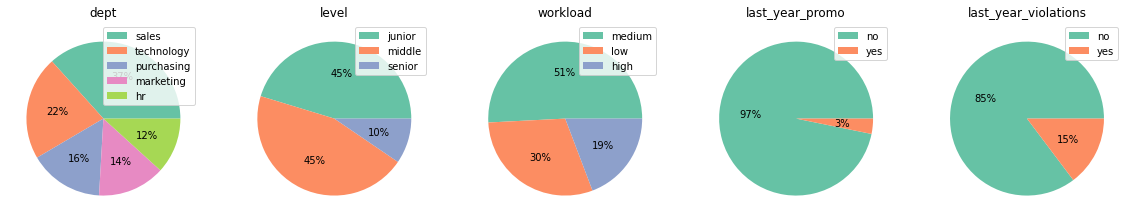

In [76]:
plot_pie(satisfaction_train)

- Самый многочисленный отдел - отдел продаж. На втором месте - технологический отдел
- В компании примерно поровну junior и middle специалистов. Senior специалисты составляют 9%
- Половина сотрудников имеют среднюю нагрузку. У 18% она высокая
- Практически все сотрудники не получали повышений ха последний год (97%)
- Нарушали условие трудового договора за последний год 15% сотрудников

**Посмотрим на категориальные признаки в разрезе целевого признака `quit`**

Катеогриальные признаки. Сотрудник ушел -  yes


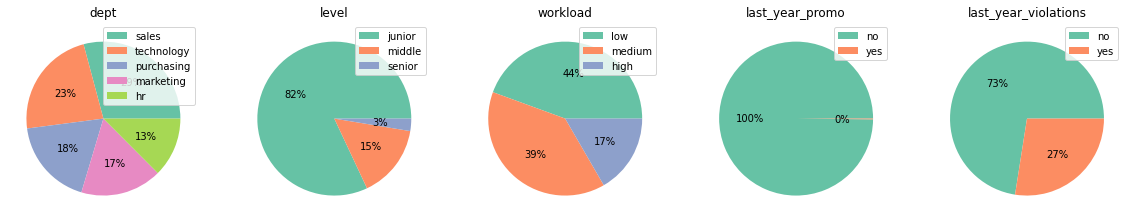

Катеогриальные признаки. Сотрудник ушел -  no


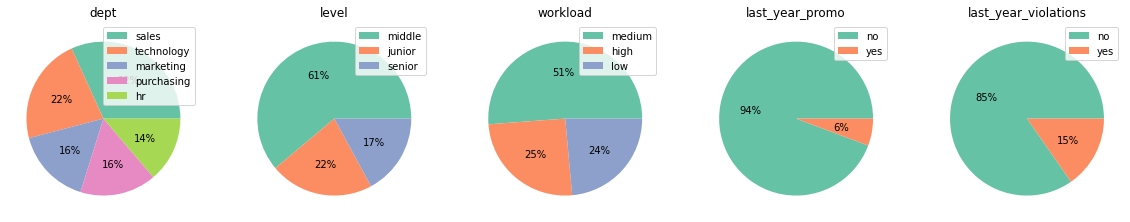

In [77]:
for quit in ['yes', 'no']:
    print('Катеогриальные признаки. Сотрудник ушел - ', quit)
    plot_pie(train_quit.query('quit == @quit').drop('quit', axis =1))
    plt.show()

- Для ушедших сотрудников характерно отсутсвие повышений за последний год и более высокий процент нарушений трудового договора за последний год
- Среди ушедших сотрудников много junior специалистов (82%). Возможно в компании нет возможностей для начинающих специалистов, которые хотят расти и подниматься по карьерной лестнице
- Соотношение отделов не изменяется для обеих выделенных групп. Это значит, что оттока кадров из какого-то определеного отдела не наблюдается

**Посмотрим на гистограммы по числовым признакам**

Основные числовые характеристики столбца employment_years:
count    2587.000000
mean        4.213375
std         2.601105
min         1.000000
25%         2.000000
50%         4.000000
75%         6.000000
max        10.000000
Name: employment_years, dtype: float64


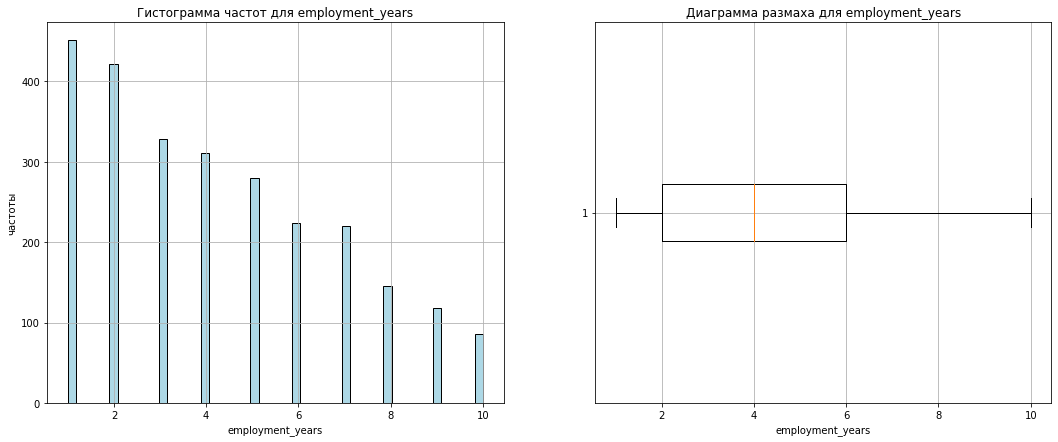

--------------------------------------------------------------------------------------------------------------

Основные числовые характеристики столбца supervisor_evaluation:
count    2587.000000
mean        3.367994
std         1.080243
min         1.000000
25%         3.000000
50%         3.000000
75%         4.000000
max         5.000000
Name: supervisor_evaluation, dtype: float64


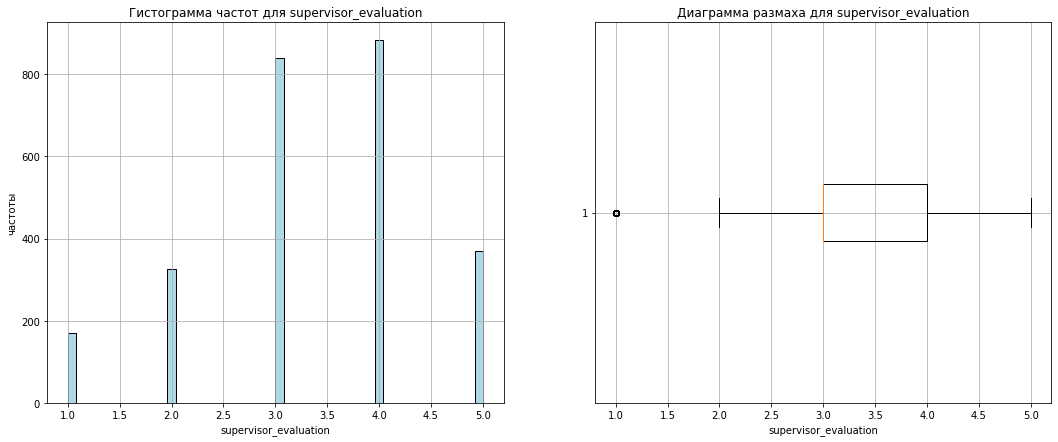

--------------------------------------------------------------------------------------------------------------

Основные числовые характеристики столбца salary:
count     2587.000000
mean     37107.692308
std      16267.354906
min      12000.000000
25%      24000.000000
50%      33600.000000
75%      46800.000000
max      96000.000000
Name: salary, dtype: float64


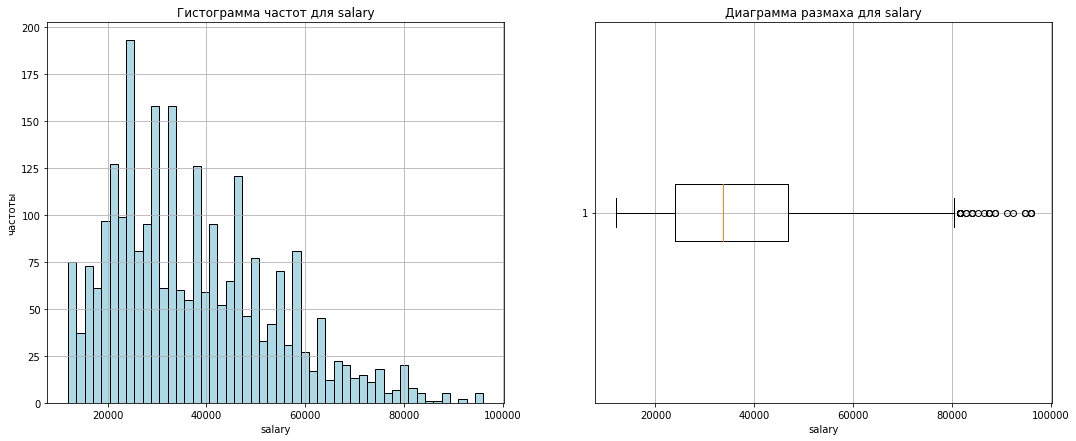

--------------------------------------------------------------------------------------------------------------



In [78]:
for i in train_quit.select_dtypes(exclude = 'object'):
    plot_hist_and_boxplot(train_quit[i])

- Большая часть сотрудников работает в компании до трех четырех лет
- Чаще всего руководители оценивали своих сторников на 4 по шкале от 1 до 5. На втором месте по частоте оценка 3. Самая редкая оценка - 1
- Распределение зарплат нессиметричное и смещено влево. Большая часть сотрудников находится левее медианной зарплаты(30тыс). Согласно диаграмме размаха зарплата выше 70тыс является редкостью


**Посмотрим на гистограммы в разрезе целевого признака**

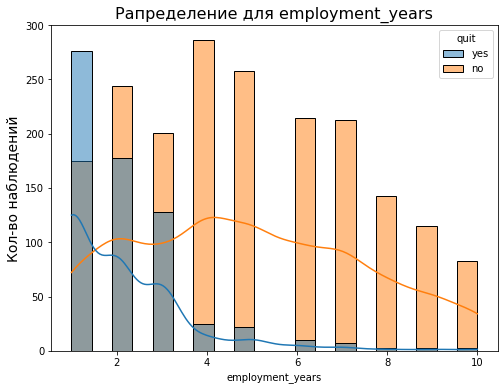

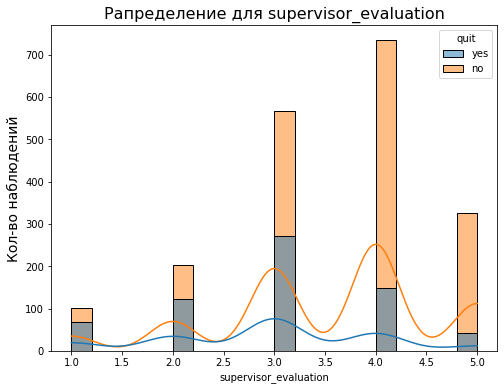

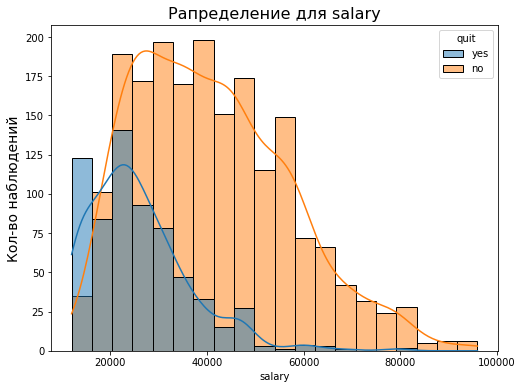

In [79]:
for col in train_quit.drop('quit', axis = 1).select_dtypes(exclude = 'object').columns:
    plot_hist(train_quit, col, 'quit')

- для сотрудников, работающих дольше в компании, характерен меньший процент увольнений. Больше всего уходят работники, проработавшие один год
- Уходившие сотрудники чаще всего получали оценку руководителя - три. Те, кто не стал увольняться, чаще всего получали оценку четыре
- Для уволившихся сотрудников характерны более низкие зарплаты, чем у тех, кто решил остаться

#### Корреляционный анализ `train_quit`

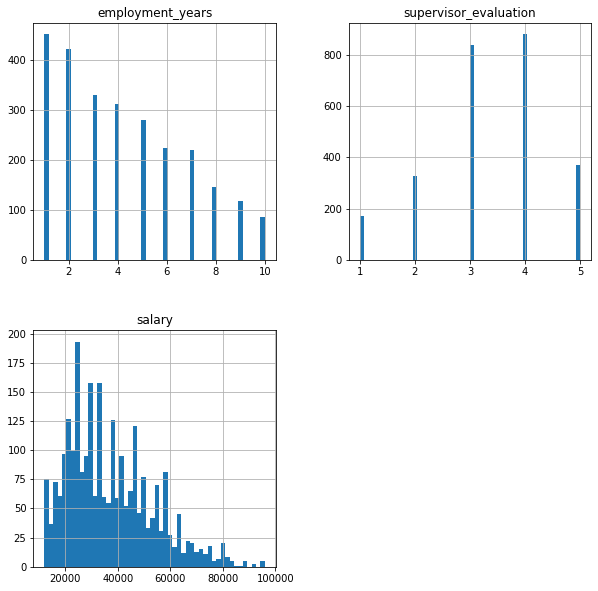

In [80]:
train_quit.hist(figsize = (10,10), bins = 50)
plt.show()

Распределения числовых признаков не похожи на нормальное, к тому же среди признаков много категориальных. Восполльзуемся phik методом

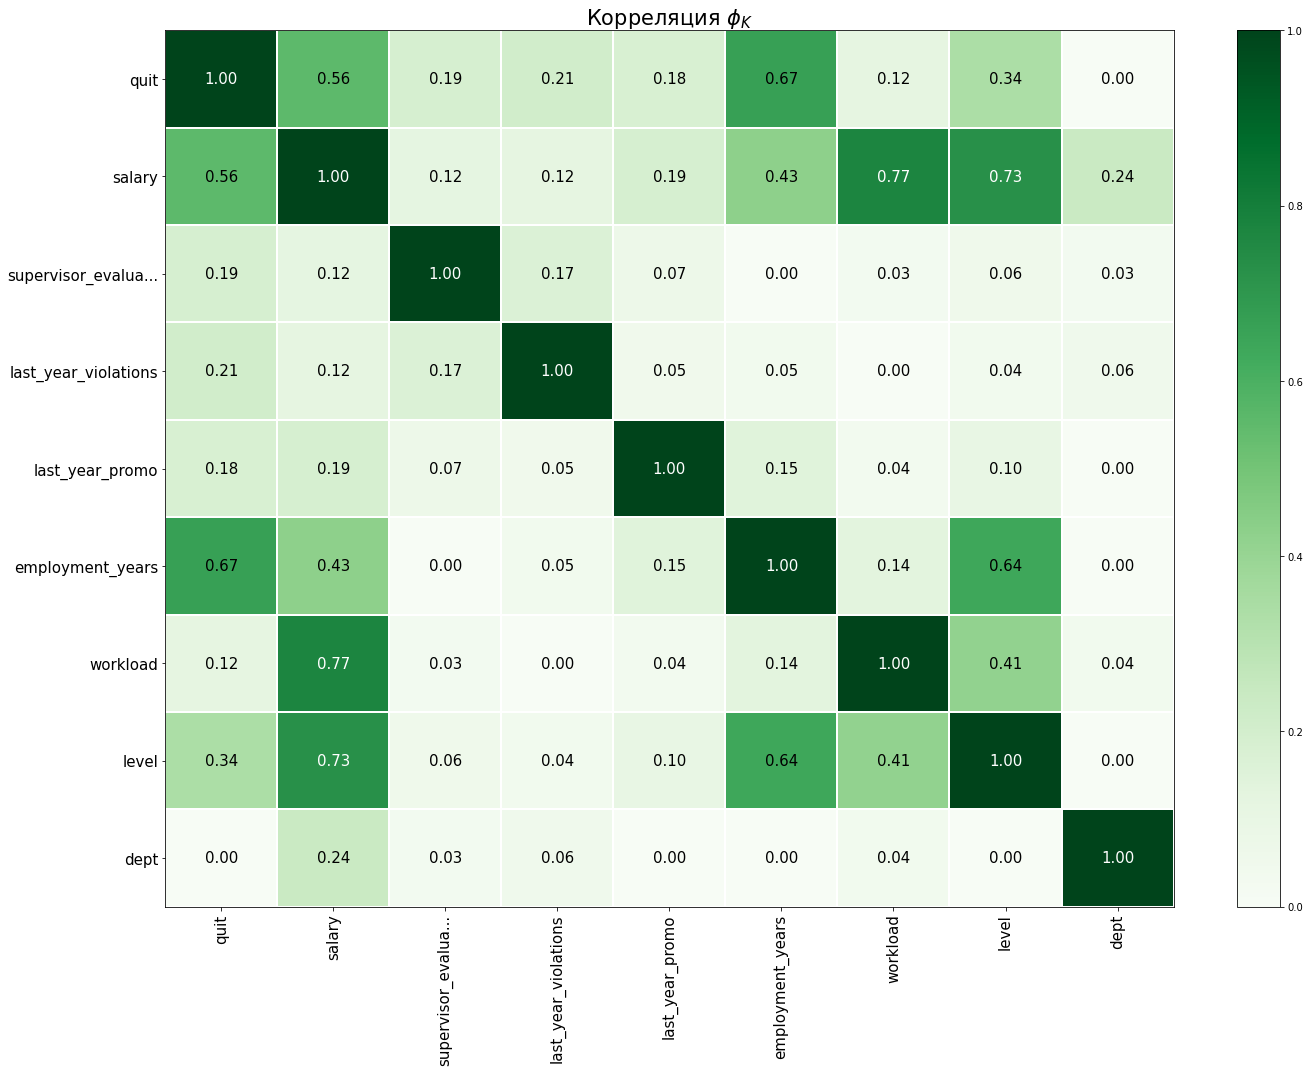

In [81]:

interval_cols = ['employment_years', 'supervisor_evaluation', 'salary']
phik_overview = phik_matrix(train_quit, interval_cols=interval_cols) 


plot_correlation_matrix(
    phik_overview.values,
    x_labels=phik_overview.columns,
    y_labels=phik_overview.index,
    vmin=0, vmax=1, color_map='Greens',
    title=r'Корреляция $\phi_K$',
    fontsize_factor=1.5,
    figsize=(20, 15)
) 

- целевой признак `quit` не коррелирует с признаком `dept`
- наблюдается высока корреляция между признаками `salary` и `workload` (0.79)
- наблюдается высока корреляция между признаками `salary` и `level` (0.75)
- средняя корреляция между признаками `level` и `employment_years`(0.69)
- признак `dept` не коррелирует ни с какими признаками, кроме `salary` (0.28 - очень слабая корреляция)

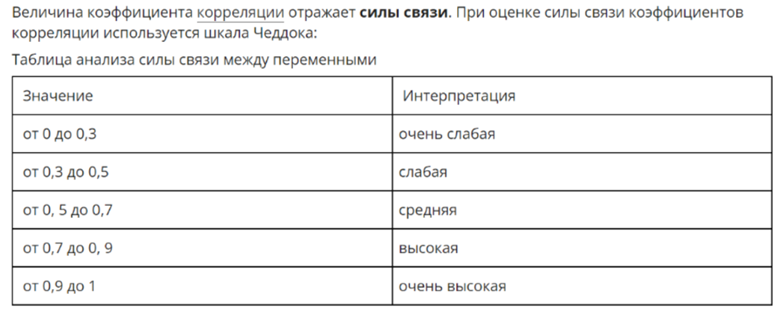

**Вывод по разделу `Исследовательский и корреляционный анализ train_quit`**
- признак `dept` не коррелирует ни с какими признаками, кроме `salary` (0.28 - очень слабая корреляция)
- наблюдается высока корреляция между признаками `salary` и `workload` (0.79)
- наблюдается высока корреляция между признаками `salary` и `level` (0.75)
- средняя корреляция между признаками `level` и `employment_years`(0.69)
- для сотрудников, работающих дольше в компании, характерен меньший процент увольнений. Больше всего уходят работники, проработавшие один год
- Уходившие сотрудники чаще всего получали оценку руководителя - три. Те, кто не стал увольняться, чаще всего получали оценку четыре
- Для уволившихся сотрудников характерны более низкие зарплаты, чем у тех, кто решил остаться
- Большая часть сотрудников работает в компании до трех четырех лет

- Для ушедших сотрудников характерно отсутсвие повышений за последний год и более высокий процент нарушений трудового договора за последний год
- Среди ушедших сотрудников много junior специалистов (89%). Возможно в компании нет возможностей для начинающих специалистов, которые хотят расти и подниматься по карьерной лестнице
- Соотношение отделов не изменяется для обеих выделенных групп. Это значит, что оттока кадров из какого-то определеного отдела не наблюдается

Таким образом, среди ушедших сотрудников очень много начинающих junior специалистов. Вероятно ввиду отсутсвия повышений и возможнотей для роста и низких зарплат, эти сотрудники уходят из компании. Эта ситуация, по видимому, является общей проблемой всей компании, а не какого-то конктретного отдела

#### Портрет уволившегося сотрудника

In [82]:
train_quit.head()

,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,quit
id,,,,,,,,,
100222,sales,junior,medium,3,no,no,2,20400,yes
100459,purchasing,junior,medium,3,no,no,3,21600,yes
100858,sales,junior,medium,2,no,no,4,25200,yes
101374,technology,middle,low,8,no,no,3,22800,no
102155,technology,middle,high,8,no,no,4,57600,no


Ранее было установлено, что среди ушедших сотрудников 89% являются junior специалистами. Доля junior специалистов в компании - 47%. Имеет смысл дополнительно исследовать выборку начинающих сотрудников, чтобы составить портрет ушедших.

In [83]:
copy = train_quit.copy()
copy['quit'] = copy['quit'].apply(lambda x: 1 if x == 'yes' else 0)
copy.head()

,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,quit
id,,,,,,,,,
100222,sales,junior,medium,3,no,no,2,20400,1
100459,purchasing,junior,medium,3,no,no,3,21600,1
100858,sales,junior,medium,2,no,no,4,25200,1
101374,technology,middle,low,8,no,no,3,22800,0
102155,technology,middle,high,8,no,no,4,57600,0


In [84]:
piv = copy.pivot_table(index = 'level', values = 'quit', aggfunc = ['sum', 'count'])
piv.columns = ['sum', 'count']
piv['fraction'] = round(piv['sum']/piv['count'], 2)
piv

,sum,count,fraction
level,,,
junior,537,958,0.56
middle,101,1282,0.08
senior,17,347,0.05


<div class="alert alert-success">
<font size="4"><b>✔️ Комментарий ревьюера V2</b></font>
    <br /> 
    <font size="3", color = "black">
<br />    
Непостоянство джунов доказано! :)

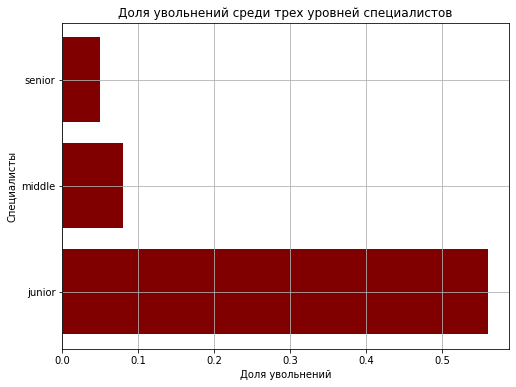

In [85]:
plt.figure(figsize= (8,6))
plt.grid()
plt.title('Доля увольнений среди трех уровней специалистов')
plt.barh(piv.index,piv['fraction'] , color='maroon')
plt.xlabel('Доля увольнений')
plt.ylabel('Специалисты')
plt.show()

<div class="alert alert-info">
Действительно среди джуниор специалистов гораздо больше увольнений, чем среди middle и senior сотрудников вместе взятых
</div>

**Посмотрим на категориальные признаки для дужниор и не джуниор специалистов**

Категориальные признаки для джуниор специалистов


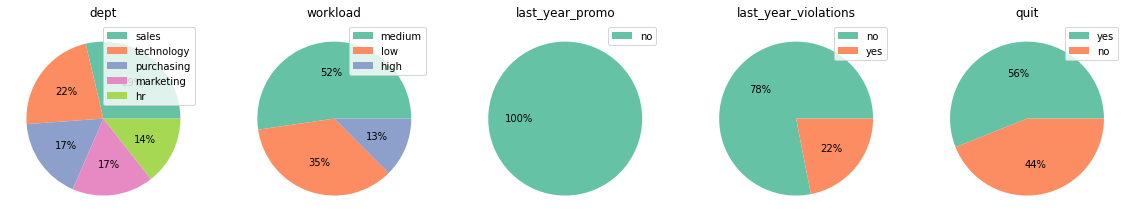

Категориалные признаки для остальных сотрудников


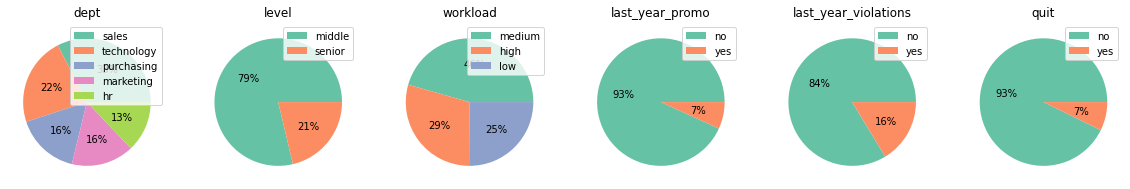

In [86]:
junior = train_quit.query('level == "junior"')
print('Категориальные признаки для джуниор специалистов')
plot_pie(junior.drop('level', axis = 1))
plt.show()
print('Категориалные признаки для остальных сотрудников')
plot_pie(train_quit.query('level != "junior"'))
plt.show()

- junior специалисты вообще не получали повышений в компании за последний год
- джуниор специалисты нарушают трудовой договор не чаще, чем мидл и сениор специалисты
- большая часть джуниор специалистов имеет среднюю нагрузку(59%) и низкую нагрузку(34%). Только 7% имеют высокую нагрузку. Возможно джунам не хватает для самореализации сложной работы
- Половина джунов клмпании в итоге уволилась. В то время как среди опытных специалистов, уволились только 6%


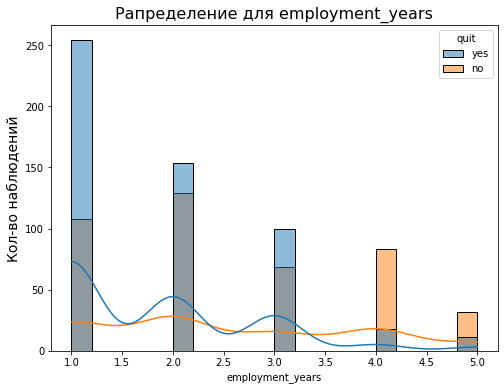

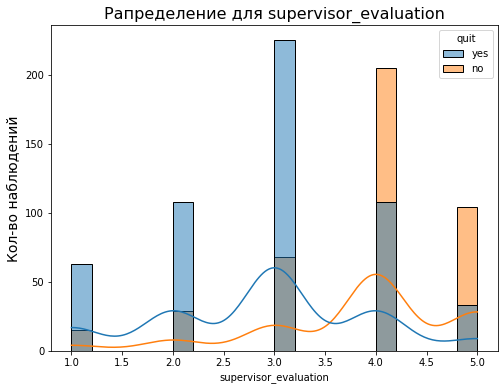

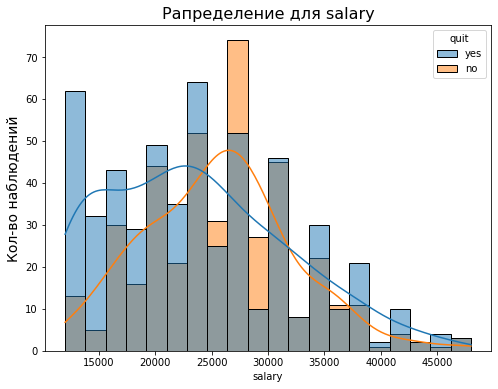

In [87]:
for col in junior.select_dtypes(exclude = 'object').columns:
    plot_hist(junior, col, 'quit')

- Среди джунов, проработавших один год, число ушедших сотрудников гораздо выше, числа оставшихся. Число оставшихся сотрудников существенно превышает число ушедших только начиная с 4го года
- Для ушедших джунов чаще всего характерна оценка руководителся три. Для оставшихся - 4
- Ушедшие джны получали более низкие зарплаты. Многие их них, получали минимальную  в компании зарплату

**Посмотрим на категориальные признаки для ушедших и оставшихся джуниор специалистов отдельно**

Категориальные признаки для джуниор специалистов 
 Признак quit yes


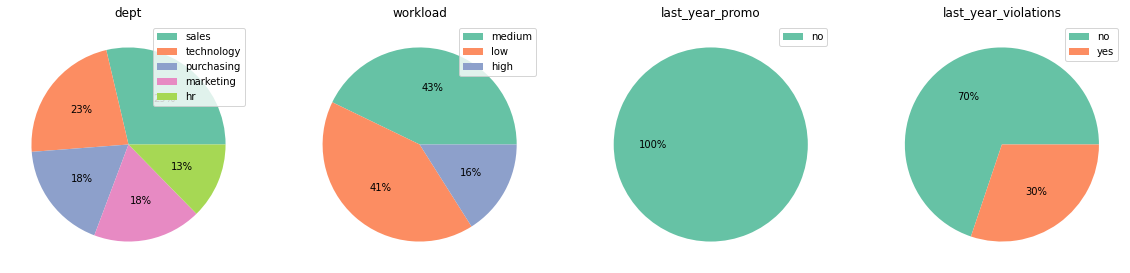

Категориальные признаки для джуниор специалистов 
 Признак quit no


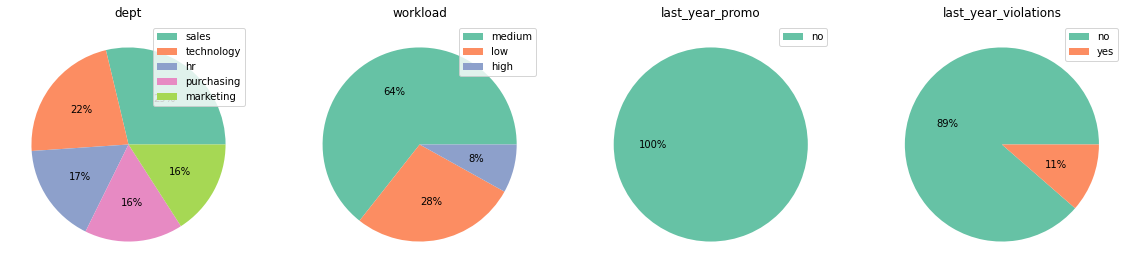

In [88]:
for quit in ['yes', 'no']:
    print('Категориальные признаки для джуниор специалистов \n Признак quit', quit)
    plot_pie(junior.query('quit == @quit').drop(['quit', 'level'], axis = 1))
    plt.show()

- для ушедших и оставшихся джунов соотношение отделов не изменяется
- Никакие джуны не получали повышений за последний год
- Среди ушедших джунов больше тех, кто нарушал условия трудового договора (21% против 9% для джунов, оставшихся в компании)
- Для ушедших джунов характерен более высокий процент низкой нагрузки (44% против 23% у оставшихся)
- Для ушедших джунов характерен более низкий процент средней нагрузки (46% против 72% у оставшихся) 

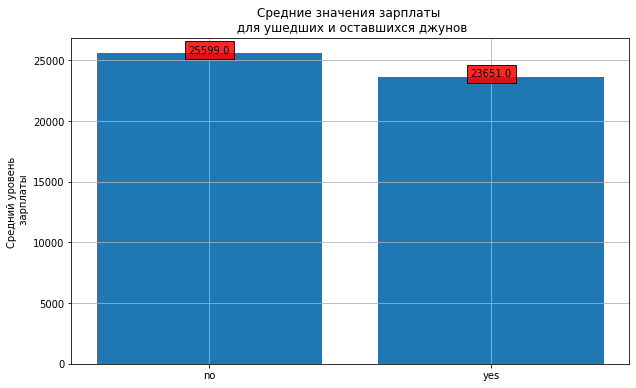

In [89]:

plt.figure(figsize=(10, 6))

pivot = junior.pivot_table(index = 'quit', values= 'salary', aggfunc ='mean')
pivot['salary'] = pivot['salary'].round()
plt.bar(x= pivot.index, height = pivot['salary'])
plt.title(f'Средние значения зарплаты \n для ушедших и оставшихся джунов')
plt.ylabel('Средний уровень \n зарплаты')
plt.grid()
addlabels(pivot.index, pivot['salary'])


- Ушедшие джуниор специалисты имеют более низкую среднюю зарплату, чем те джуны, которые решили остаться (22508 против 25662). В процентах их средняя зарплата меньше на 12%

**Портрет уходящего сотрудника**
- Большинство ушедших сотрудников являются джуниор специалистами. Ранее было установлено, что среди ушедших сотрудников 89% являются junior специалистами. В компании ни один джуниор специалист не получал повышений за последний год, при этом они нарушают условия трудового договора не чаще чем мидл и сениор специалисты. 
- Половина джунов компании в итоге уволилась. В то время как среди опытных специалистов, уволились только 6%
- В основном джуниор специалисты уходят в первый год работы
- Для ушедших джунов чаще всего характерна оценка руководителся три
- Ушедшие дужны получали более низкие зарплаты. Многие их них, получали минимальную  в компании зарплату. Зарплата ушедшего джуниор специалиста на 12% меньше зарплаты оставшихся джунов. 
- Джуны не уходят из какого-то конкретного отдела
- Среди ушедших джунов больше тех, кто нарушал условия трудового договора (21% против 9% для джунов, оставшихся в компании)
- Джуны, ушедшие их компании чаще имеют низкую нагрузку и реже среднюю. Возможно они уходят, потому что хотели бы работать больше и получать повышение, но работы не хватает


#### Проверим, что  удовлетворённость сотрудника  влияет на его уход из компании

In [90]:
test_features.head()

,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary
id,,,,,,,,
100298,hr,junior,low,2,no,no,4,19200
100480,marketing,junior,low,4,no,no,4,16800
100503,purchasing,middle,high,5,no,no,4,55200
100610,sales,middle,medium,5,no,no,4,43200
100692,sales,middle,high,6,no,no,4,48000


In [91]:
test_target.head()

,quit
id,
100298,no
100480,no
100503,no
100610,no
100692,no


In [92]:
satisfaction_y_test.head()

,job_satisfaction_rate
id,
100298,0.80
100480,0.84
100503,0.79
100610,0.75
100692,0.69


Создадим датасет с объединеными целевыми признаками `quit` и `job_satisfaction_rate`, а также с входными тестовыми признаками

In [93]:
joined = test_features.join([test_target, satisfaction_y_test])
joined.head()

,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,quit,job_satisfaction_rate
id,,,,,,,,,,
100298,hr,junior,low,2,no,no,4,19200,no,0.80
100480,marketing,junior,low,4,no,no,4,16800,no,0.84
100503,purchasing,middle,high,5,no,no,4,55200,no,0.79
100610,sales,middle,medium,5,no,no,4,43200,no,0.75
100692,sales,middle,high,6,no,no,4,48000,no,0.69


**Посмотрим на распределение уровня удовлетворенности работников в разрезе по второму целевому признаку `quit`**

Числовые характеристики уровня удовлетворенности. Признак quit -  yes
count    564.000000
mean       0.387713
std        0.185784
min        0.040000
25%        0.240000
50%        0.370000
75%        0.492500
max        0.970000
Name: job_satisfaction_rate, dtype: float64

--------------------------------------------------
Числовые характеристики уровня удовлетворенности. Признак quit -  no
count    1436.000000
mean        0.612040
std         0.199367
min         0.030000
25%         0.500000
50%         0.660000
75%         0.760000
max         1.000000
Name: job_satisfaction_rate, dtype: float64

--------------------------------------------------


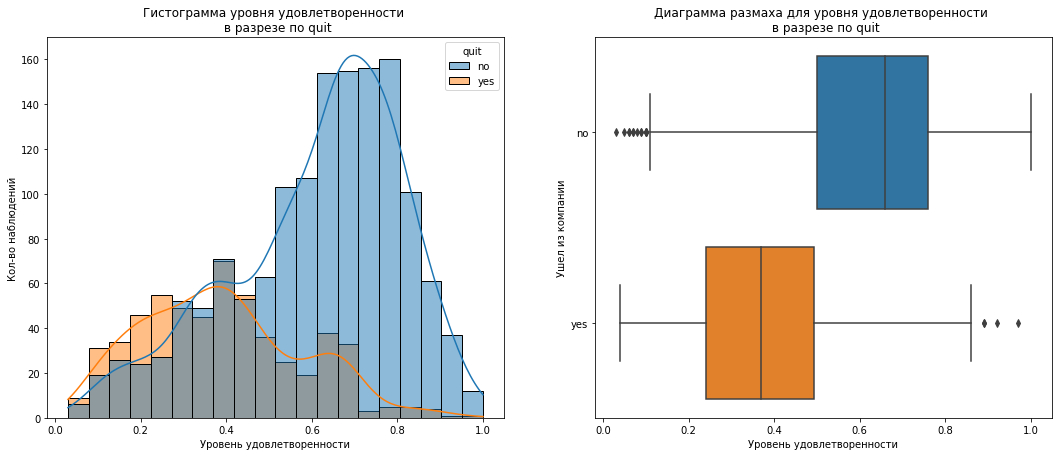

In [94]:

fig, axs = plt.subplots(1, 2, figsize = (18, 7))
sns.histplot(joined, bins=20, kde=True, hue='quit', x='job_satisfaction_rate', ax = axs[0])
axs[0].set_title('Гистограмма уровня удовлетворенности \n в разрезе по quit')
axs[0].set_xlabel('Уровень удовлетворенности')
axs[0].set_ylabel('Кол-во наблюдений')
sns.boxplot(data = joined, x = 'job_satisfaction_rate', y = 'quit', ax = axs[1])
axs[1].set_title('Диаграмма размаха для уровня удовлетворенности \n в разрезе по quit')
axs[1].set_xlabel('Уровень удовлетворенности')
axs[1].set_ylabel('Ушел из компании')
for i in ['yes', 'no']:
    print('Числовые характеристики уровня удовлетворенности. Признак quit - ', i)
    print(joined.query('quit == @i')['job_satisfaction_rate'].describe())
    print()
    print('-'*50)
plt.show()

**Взаимосвязь уровня удовлетворенности и ухода из компании**


Действительно, ушедшие сотрудники имели гораздо более низкий средний и медианный уровень удовлетворенности. У оставшихся сотрудников эти показатели в два раза выше, чем у ушедших. Распределение уровня удовлетворенности на гистограмме для ушеших сотрудников смещено левее. Диаграмма размаха тоже смещена влево, относително оставшихся сотрудников. На диаграмме размаха также видно, что высокие значения уровня удовлетворенности для ушедших сотрудников - редкость

### Добавление нового входного признака

**Добавим в `train_quit` спрогнозированный первой моделью новый признак `job_satisfaction_rate`**

In [95]:
train_quit.head()

,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,quit
id,,,,,,,,,
100222,sales,junior,medium,3,no,no,2,20400,yes
100459,purchasing,junior,medium,3,no,no,3,21600,yes
100858,sales,junior,medium,2,no,no,4,25200,yes
101374,technology,middle,low,8,no,no,3,22800,no
102155,technology,middle,high,8,no,no,4,57600,no


In [96]:

train_quit['job_satisfaction_rate'] = randomized_search.predict(train_quit.drop(['dept', 'quit'], axis = 1))
train_quit.head()

,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,quit,job_satisfaction_rate
id,,,,,,,,,,
100222,sales,junior,medium,3,no,no,2,20400,yes,0.341406
100459,purchasing,junior,medium,3,no,no,3,21600,yes,0.338361
100858,sales,junior,medium,2,no,no,4,25200,yes,0.824615
101374,technology,middle,low,8,no,no,3,22800,no,0.353458
102155,technology,middle,high,8,no,no,4,57600,no,0.824938


**Добавим в `test_features` спрогнозированный первой моделью новый признак `job_satisfaction_rate`**

In [97]:
test_features.head()

,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary
id,,,,,,,,
100298,hr,junior,low,2,no,no,4,19200
100480,marketing,junior,low,4,no,no,4,16800
100503,purchasing,middle,high,5,no,no,4,55200
100610,sales,middle,medium,5,no,no,4,43200
100692,sales,middle,high,6,no,no,4,48000


In [98]:

test_features['job_satisfaction_rate'] = randomized_search.predict(test_features.drop('dept', axis = 1))
test_features.head()

,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,job_satisfaction_rate
id,,,,,,,,,
100298,hr,junior,low,2,no,no,4,19200,0.839839
100480,marketing,junior,low,4,no,no,4,16800,0.839155
100503,purchasing,middle,high,5,no,no,4,55200,0.770772
100610,sales,middle,medium,5,no,no,4,43200,0.815695
100692,sales,middle,high,6,no,no,4,48000,0.695191


**Вывод по разделу `Добавление нового входного признака`**

Добавили новый признак `job_satisfaction_rate`, предсказанный первой моделью в датасеты `train_quit` и `test_features`

### Подготовка данных

Подготовка данных и заполнение пропусков будут произведены в итоговом пайплайне. Ohe кодирование для колонок:
- `last_year_promo`
- `last_year_violations`

Ord кодирование для колонок:
- `level`
- `workload`

StandardScaler или MinMaxScaler для колонок:
- `employment_years`
- `supervisor_evaluation`
- `salary`
- `job_satisfaction_rate`

### Обучение модели

In [99]:
train_quit.head()

,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,quit,job_satisfaction_rate
id,,,,,,,,,,
100222,sales,junior,medium,3,no,no,2,20400,yes,0.341406
100459,purchasing,junior,medium,3,no,no,3,21600,yes,0.338361
100858,sales,junior,medium,2,no,no,4,25200,yes,0.824615
101374,technology,middle,low,8,no,no,3,22800,no,0.353458
102155,technology,middle,high,8,no,no,4,57600,no,0.824938


In [100]:
test_features.head()

,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,job_satisfaction_rate
id,,,,,,,,,
100298,hr,junior,low,2,no,no,4,19200,0.839839
100480,marketing,junior,low,4,no,no,4,16800,0.839155
100503,purchasing,middle,high,5,no,no,4,55200,0.770772
100610,sales,middle,medium,5,no,no,4,43200,0.815695
100692,sales,middle,high,6,no,no,4,48000,0.695191


In [101]:
test_target.head()

,quit
id,
100298,no
100480,no
100503,no
100610,no
100692,no


Первую модель обучал без признака `dept`, поскольку так метрики были выше. Учитывая то, что `dept` почти не коррелировал ни с одним другим признаком, а соотношение отделов не менялось в ходе исследовательского анализа для разных выделенных групп, думаю и сейчас можно обойтись без этого признака

**Посчитаем кол-во `no` и `yes` в тренировочной и тестовой выборке**

In [102]:
train_quit['quit'].value_counts()

no     1932
yes     655
Name: quit, dtype: int64

In [103]:
test_target.value_counts()

quit
no      1436
yes      564
dtype: int64

**Соотношение между классами примерно одно и тоже на тренировочной и тестовой выборке, это хорошо**

In [104]:

warnings.filterwarnings('ignore')

X_train = train_quit.drop(['quit', 'dept'], axis =1)
y_train = train_quit['quit']
X_test = test_features.drop('dept', axis = 1)
y_test = test_target



ohe_columns2 = ['last_year_promo', 'last_year_violations']
ord_columns2 = ['level', 'workload']
num_columns2 = ['employment_years', 'supervisor_evaluation', 'salary', 'job_satisfaction_rate']




ohe_pipe2 = Pipeline(
    [('simpleImputer_ohe', SimpleImputer(missing_values= np.nan, strategy = 'most_frequent')),
      ('ohe', OneHotEncoder(drop = 'first', handle_unknown = 'error')) #ПРАВКА РЕВЬЮЕРА
    ]
)



ord_pipe2 = Pipeline(
    [('simpleImputer_before_ord', SimpleImputer(missing_values = np.nan, strategy = 'most_frequent')),
     ('ord', OrdinalEncoder(categories = [['junior', 'middle', 'senior'],
                                         ['low', 'medium','high']],
                           handle_unknown = 'use_encoded_value', unknown_value = np.nan)),
     ('simpleImputer_after_ord', SimpleImputer(missing_values = np.nan, strategy = 'most_frequent'))
    ]
)


data_preprocessor2 = ColumnTransformer(
    [('ohe', ohe_pipe2, ohe_columns2),
     ('ord', ord_pipe2, ord_columns2),
     ('num', StandardScaler(), num_columns2)
    ],
    remainder = 'passthrough'
)


pipe_final2 = Pipeline(
    [('preprocessor', data_preprocessor2),
     ('models', LogisticRegression(random_state = RANDOM_STATE, class_weight = 'balanced'))
    ]
)

param_grid2 = [
    {
        'models' : [DecisionTreeClassifier(random_state=RANDOM_STATE)],
        'models__max_depth': range(2,6),
        'models__max_features' : range(2,6),
        'preprocessor__num' : [StandardScaler(), MinMaxScaler(), 'passthrough']
    },
    {
        'models' : [LogisticRegression(random_state = RANDOM_STATE, class_weight = 'balanced')],
        'models__C' : range(1, 5),
        'models__penalty' : ['l1','l2'],
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']
    },
    {
        'models' : [KNeighborsClassifier()],
        'models__n_neighbors' : range(2,6),
        'preprocessor__num' : [StandardScaler(), MinMaxScaler(), 'passthrough']},
    {
        'models' : [SVC(random_state = RANDOM_STATE, probability=True)],
        'models__kernel' : ['rbf', 'linear', 'sigmoid', 'poly'],
        'models__degree' : range(1,10),
        'models__C' : range(1, 5)
    }
    
]



randomized_search2 = RandomizedSearchCV(
    pipe_final2,
    param_grid2,
    cv = 5,
    scoring= 'roc_auc',
    random_state = RANDOM_STATE,
    n_jobs = -1
)





randomized_search2.fit(X_train, y_train)

RandomizedSearchCV(cv=5,
                   estimator=Pipeline(steps=[('preprocessor',
                                              ColumnTransformer(remainder='passthrough',
                                                                transformers=[('ohe',
                                                                               Pipeline(steps=[('simpleImputer_ohe',
                                                                                                SimpleImputer(strategy='most_frequent')),
                                                                                               ('ohe',
                                                                                                OneHotEncoder(drop='first'))]),
                                                                               ['last_year_promo',
                                                                                'last_year_violations']),
                                               

In [105]:
print('Лучшая модель и её параметры:\n\n', randomized_search2.best_estimator_)
print ('Метрика лучшей модели на кроссвалидации:', randomized_search2.best_score_)

Лучшая модель и её параметры:

 Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ohe',
                                                  Pipeline(steps=[('simpleImputer_ohe',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('ohe',
                                                                   OneHotEncoder(drop='first'))]),
                                                  ['last_year_promo',
                                                   'last_year_violations']),
                                                 ('ord',
                                                  Pipeline(steps=[('simpleImputer_before_ord',
                                                                   SimpleImputer(strategy='most_frequent')),
                                        

**Параметры лучшей модели**

In [106]:
randomized_search2.best_params_

{'models__kernel': 'rbf',
 'models__degree': 3,
 'models__C': 4,
 'models': SVC(C=4, probability=True, random_state=42)}

In [107]:
y_test_pred_proba = randomized_search2.predict_proba(X_test)
print(f'Метрика ROC-AUC на тестовой выборке: {roc_auc_score(y_test, y_test_pred_proba[:,1])}')

Метрика ROC-AUC на тестовой выборке: 0.9233637566921512


Отличные новости.Лучшая модель - метод опорных векторов, показала метрика `roc_auc` на тестовой выборке `0.92`

**Вывод по разделу `Обучение модели. Задача 2`**

Вторая модель также обучалась без признака `dept`

- **В пайплайне были перебраны методом случайного перебора 4 модели машинного обучения. Логистическая регрессия, метод опорных векторов, дерево решений и метод k-ближайших соседей**
    - Для дерева решений перебирались параметры максимальной глубины и кол-во учитываемых при разбиении признаков
    - Для логистической регрессии перебирались два типа регуляризации l1 и l2, а также сила модели 
    - Для k-ближайших соседей перебиралось число ближайших соседей
    - Для метода опорных векторов перебирались: ядро('rbf', 'linear', 'sigmoid', 'poly'), а также степень и сила модели



- **Лучшей моделью на кроссвалидации, показавшей метрику `ROC_AUC ~0.9220`, стала SVM с параметрами:**
    - ядро радиальной базисной функции
    - сила модели 4
    
    
Ядро радиальной базисной функции очень хорошо работает на нелинейных данных. То что методом опорных векторов с этим ядром оказался лучшей моделью означает, что скорее всего данные носили довольно сложный нелинейный характер. Тем не менее, учитывая сложность ядра `rbf`, модель не переучилась и показала такую же высокую метрику `roc_auc` и на тестовых данных


- **Остановимся на лучшей модели `SVM ядро радиальной базисной функции, сила модели 4`, показавшей среднее значение метрики `ROC_AUC 0.9208` при кроссвалидации и `ROC_AUC 0.9220` на тестовых данных**


## Общий вывод

Задачей проекта, было предсказание ухода сотрудников из компании. В ходе исследования данных было установлено, что в основном уходят `junior` специалисты в первый год своей работы. Они не получают повышений и в большинстве своем имеют низкий уровень нагрузки и низкие, а иногда и минимальные по компании зарплаты. Полагаю им недостаточно задач для самореализации и роста в профессиональном плане. Также на уход сотрудника влиет наличие нарушений трудового договора. Если они присутвуют, то работник находится в зоне риска. 

В ходе выполнения проекта были построены две модели. Первая прогнозирует уровень удовлетворенности сотрудника, который, как выяснилось, напрямую влияет на уход из компании. Вторая модель, основываясь на прогнозах первой (признак уровень удовлетворенности работника), предсказывает уйдет работник из компании или нет

### Задача 1. Предсказание уровня удовлетворенности

В ходе задачи 1 нужно было построить модель, предсказывающую уровень удовлетворенности работника от трудовой деятельности в компании. 

**Вывод по разделу `Предобработка Задача 1`**

- При загрузке данные считались верно. Типы данных корректны, но есть пропуски, которые будут заполнены в итоговом пайплайне


**Вывод по разделу `Исследовательский анализ satisfaction_train`**

- Самый многочисленный отдел - отдел продаж. На втором месте - технологический отдел
- В компании примерно поровну junior и middle специалистов. Senior специалисты составляют 9%
- Практически все сотрудники не получали повышений за последний год (97%)
- Нарушали условие трудового договора за последний год 14% сотрудников
- Среди сотрудников компании много тех, кто проработал до трех лет


- Между уровнем удовлетвороренности и оценкой руководителя существует прямая связь
- Различима прямая зависимость между уровнем удовлетворенности и зарплатой
- Наличие нарушений трудового договора за последний год очень часто характерно для низкого уровня удовлетворенности сотрудника
- Уровень удовлетворенности завист от наличия повышений за последний год и наличия нарушений трудового договора за последний год. 





**Введем определение. Работники с низким уровнем удовлетворенности это < 0.25. Работники с выоским уровнем удовлетворенности это > 0.75**
- Работники высокого и низкого уровня удовлетворенности одинаково распределены по отделам. Значит проблемных отделов нет
- Самое яркое различие между работниками с низкой и высокой удовлетворенностью заключается в наличии нарушений трудового договора. У работников с высоким уровнем удовлетворенности вообще нет нарушений, в то время как половина неудовлетворенных сотрудников нарушали трудовой договор
- Среди работников с низким уровнем удовлетворенности очень много тех, кто отработал один год. Среди тех, кто отработал два года наоборот много тех, кто имеет высокий уровень удовлетворенности. 
- Среди тех, кто уже давно работает в компании (более 4 лет), заметно больше работников с высоким уровнем удовлетворенности
- Работники с низким уровнем удовлетворенности никогда не получали оценку от руководителя выше тройки. Среди тех, кто получил 4 и 5 наоборот одни довольные работники только
- Для довольных работников характерны более высокие зарплаты



**Таким образом, наиболее существенными показателями можно считать: наличие нарушений трудового договора, наличие повышений, оценка руководителя и уровень зарплаты. Принадлежность к какому-либо отделу скорее всего не влияет на уровень удовлетворенности**

**Вывод по разделу `Исследовательский анализ данных satisfaction_test`**
Данные тестовой выборки очень похожи на данные тренировочной. За некоторыми неглобальными различиями

**Вывод по разделу `Обучение моделей. Задача 1`**

В пайплайне методом случайного поиска были опробованы две модели: линейная регрессия и регрессия дерева решений. Для случайного леса подбирались параметры:
- max_depth (от 2 до 22)
- min_samples_split (от 2 до 22)
- max_features (от 2 до 22)
- n_estimators (от 100 до 1000)


При подготовке числовых данных пробовал два кодировщика. StandardScaler и MinMaxScaler

Качество модели оценивалось метрикой `smape` «симметричное среднее абсолютное процентное отклонение»

**Лучшая модель - случайный лес**
- `min_samples_split` -  9
- `max_features` -  7
- `max_depth` - 21
- `n_estimators` - 377

**Нужна метрика smape <= 15. Имеем  на кроссвалидации 15.91 и 14.58 на тесте**

### Задача 2. Предсказание ухода сотрудника

В ходе задачи 2 нужно было добавить новый признак - уровень удовлетворенности, спрогнозированый первой моделью, и на основе имеющихся данных построить модель для предсказания уходя сотрудника. Задача классификации по двум классам `yes`, `no`

**Вывод по разделу `Предобработка. Задача 2`**
- Данные в порядке, пропусков нет, типы данных считались корректно. Заменил `sinior` на `senior` в столбце `level` датасета `train_quit`


**Вывод по разделу `Исследовательский и корреляционный анализ train_quit`**
- признак `dept` не коррелирует ни с какими признаками, кроме `salary` (0.28 - очень слабая корреляция)

- для сотрудников, работающих дольше в компании, характерен меньший процент увольнений. Больше всего уходят работники, проработавшие один год
- Уходившие сотрудники чаще всего получали оценку руководителя - три. Те, кто не стал увольняться, чаще всего получали оценку четыре
- Для уволившихся сотрудников характерны более низкие зарплаты, чем у тех, кто решил остаться
- Для ушедших сотрудников характерно отсутсвие повышений за последний год и более высокий процент нарушений трудового договора за последний год
- Среди ушедших сотрудников много junior специалистов (89%). Возможно в компании нет возможностей для начинающих специалистов, которые хотят расти и подниматься по карьерной лестнице
- Соотношение отделов не изменяется для обеих выделенных групп. Это значит, что оттока кадров из какого-то определеного отдела не наблюдается

Таким образом, среди ушедших сотрудников очень много начинающих junior специалистов. Вероятно ввиду отсутсвия повышений и возможнотей для роста и низких зарплат, эти сотрудники уходят из компании. Эта ситуация, по видимому, является общей проблемой всей компании, а не какого-то конктретного отдела

**Портрет уходящего сотрудника**


Уходящий сотрудник как правило имеет уровень квалификации `junior` и уходит в первый год работы. Такие сотрудники чаще всего получают оценку руководителя - три и имеют более низкие, чем у оставшихся джунов, или вовсе минимальные в компании зарплаты. Также для уходящего сотрудника чаще характерно наличие нарушений трудового договора. Не наблюдается оттока работников из определенного отдела, сотрудники покидают отделы равномерно. В основном уходящие джуны имеют низкую нагрузку, учитывая то, что никакие джуниор специалисты не получали повышений за последний год, возможно начинающие специалисты уходят в первый год работы из-за недостатка сложной работы, засчет которой можно вырасти и получить повышение.


**Взаимосвязь уровня удовлетворенности и ухода из компании**


Действительно, ушедшие сотрудники имели гораздо более низкий средний и медианный уровень удовлетворенности. У оставшихся сотрудников эти показатели в два раза выше, чем у ушедших. Распределение уровня удовлетворенности на гистограмме для ушеших сотрудников смещено левее. Диаграмма размаха тоже смещена влево, относително оставшихся сотрудников. На диаграмме размаха также видно, что высокие значения уровня удовлетворенности для ушедших сотрудников - редкость

**Вывод по разделу `Добавление нового входного признака`**

Добавили новый признак `job_satisfaction_rate`, предсказанный первой моделью в датасеты `train_quit` и `test_features`

**Вывод по разделу `Обучение модели. Задача 2`**

Вторая модель также обучалась без признака `dept`

- **В пайплайне были перебраны методом случайного перебора 4 модели машинного обучения. Логистическая регрессия, метод опорных векторов, дерево решений и метод k-ближайших соседей**
    - Для дерева решений перебирались параметры максимальной глубины и кол-во учитываемых при разбиении признаков
    - Для логистической регрессии перебирались два типа регуляризации l1 и l2, а также сила модели 
    - Для k-ближайших соседей перебиралось число ближайших соседей
    - Для метода опорных векторов перебирались: ядро('rbf', 'linear', 'sigmoid', 'poly'), а также степень и сила модели



- **Лучшей моделью на кроссвалидации, показавшей метрику `ROC_AUC ~0.9220`, стала SVM с параметрами:**
    - ядро радиальной базисной функции
    - сила модели 4
    
    
Ядро радиальной базисной функции очень хорошо работает на нелинейных данных. То что методом опорных векторов с этим ядром оказался лучшей моделью означает, что скорее всего данные носили довольно сложный нелинейный характер. Тем не менее, учитывая сложность ядра `rbf`, модель не переучилась и показала такую же высокую метрику `roc_auc` и на тестовых данных


- **Остановимся на лучшей модели `SVM ядро радиальной базисной функции, сила модели 4`, показавшей среднее значение метрики `ROC_AUC 0.9208` при кроссвалидации и `ROC_AUC 0.9220` на тестовых данных**


## Рекомендации

В компании почти половина сотрудников является джуниор специалистами (45%). Согласно проведенному исследованию, процент увольнений среди джунов гораздо выше, чем процент увольнения мидл и сениор специалистов вместе взятых (0.56  0.8  0.5 соотвественно). Исходя из этого можно заключить, что джуниор специалисты являются проблемной группой, на которую компании следует обратить свое внимание. В группе риска находятся джуниор специалисты недавно работающие в компании (поскольку чаще всего они уходят в первый год работы), имеющие низкие зарплаты, получающие оценку руководителя 3, имеющие нарушения трудового договора. Среди оставшихся в компании джунов гораздо больше тех, кто имеет среднюю нагрузку. Для уходящих джунов характерен более высокий процент людей, имеющих низкую нагрузку. Более того, ни один джуниор специалист не получал повышений за последний год. Возможно, причина ухода джуниор специалистов в первый год работы, связана с тем, что начинающим специалистам не хватает интересных задач, которые могли бы повысить их проффесионализм и стимулировать карьерный рост. Мой совет - уделить внимание развитию своих начинающих специалистов во всех отделах. Давать им задачи, на которых они будут учиться новому и развиваться в профессии. В этот процесс полезно будет вовлечь midlle или senior специалистов, которые будут помогать с трудностями и объяснять ошибки новичков